In [1]:
import os
import sys
import json
from scipy import stats
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, ShuffleSplit
from tqdm import tqdm
import warnings
import matplotlib as mpl
import plot_utils
import umap
import pandas as pd
import logomaker as lm

warnings.filterwarnings('ignore', 'invalid value encountered in true_divide')

## Settings

In [2]:
TEXTWIDTH = 6.7261  # in
DPI = 360

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

## Colors

In [5]:
ot1_color = 'tab:green'
palette_tcrs = {'OT1': ot1_color, 
                'OTI': ot1_color, 
                'OT-I': ot1_color, 
                'Educated': 'tab:orange',
                'Naive': 'tab:blue',
                'Naïve': 'tab:blue',
               }
palette_naive_test = 'Blues'
palette_educated_test = 'Oranges'
palette_naive_ot1 = 'Greens'
color_random ='silver'
color_mice = 'silver'

palette_educated = sb.color_palette('Oranges', 16)[:8]

color_mice = 'silver'
color_cdr3 = 'violet'
cmap_distances = 'viridis_r'

## Helper functions

In [6]:
def assign_repertoire(tcr):
    tcr = tcr.upper()
    if tcr == 'OTI':
        return 'OTI'
    if tcr.startswith('ED'):
        return 'Educated'
    return 'Naive'

## Load Data

In [7]:
def load_tcr_dists():
    dists = pd.read_excel('../results/TCRdists.xlsx', 'murine', index_col=0)
    dists.index = dists.index.str.upper()
    dists.columns = dists.columns.str.upper()
    rename_dict = {'OT1': 'OTI'}
    dists = dists.rename(columns=rename_dict, index=rename_dict)
    return dists
tcrdist_mice = load_tcr_dists()

In [8]:
def compute_classification_metrics(g):
    return pd.Series({
        'AUC': (
            metrics.roc_auc_score(g['is_activated'], g['pred'])
            if np.isfinite(g['pred']).all() and 0 < g['is_activated'].mean() < 1
            else np.nan
        ),
        'APS': (
            metrics.average_precision_score(g['is_activated'], g['pred'])
            if np.isfinite(g['pred']).all()
            else np.nan
        ),
    })

In [9]:
def compute_regression_metrics(g):
    return pd.Series({
        'MAE': g['abserr'].mean(),
        'R2': metrics.r2_score(g['activation'], g['pred']),
        'Pearson': g['activation'].corr(g['pred'], method='pearson'),
        'Spearman': g['activation'].corr(g['pred'], method='spearman'),
    })

In [10]:
def load_naive_test_data():
    fname = '../activation-prediction/results/cross-performance-educated-vs-naive.csv.gz'
    pdf = pd.read_csv(fname)
    pp = pdf.query('~is_educated').groupby(
        'tcr', as_index=False
    ).apply(compute_classification_metrics)
    return pp
naive_test_data = load_naive_test_data()

In [11]:
def load_educated_test_data():
    fname = '../activation-prediction/results/cross-performance-naive-vs-educated.csv.gz'
    pdf = pd.read_csv(fname)
    pdf = pdf[pdf['is_educated'] | (pdf['tcr']=='OTI')]
    pp = pdf.groupby(
        'tcr', as_index=False
    ).apply(compute_classification_metrics)
    return pp
educated_test_data = load_educated_test_data()

In [12]:
def load_classification_data():
    fname = f'../activation-prediction/results'
    pdf = pd.read_csv(f'{fname}/SIINFEKL_tcr_stratified_classification_performance.csv.gz')
    
    pdf = pdf[pdf['normalization']=='AS']
    pdf = pdf[pdf['threshold']==46.9]
    pdf = pdf[pdf['reduced_features']]
    
    pdf = pdf.query('mut_pos >= 0')
    pdf = pdf.groupby([
        'normalization', 'tcr'
    ]).filter(lambda g: 0 < g['is_activated'].sum() < len(g) - 1)

    pdf['Repertoire'] = pdf['tcr'].apply(assign_repertoire)

    df_metrics = pdf.groupby(['tcr'], as_index=False).apply(compute_classification_metrics).reset_index()

    df_metrics['Repertoire'] = df_metrics['tcr'].apply(assign_repertoire)
    return pdf, df_metrics
pdf_classification, df_classification_metrics = load_classification_data()

In [13]:
df_classification_metrics['Repertoire'].value_counts()

Educated    15
Naive        9
OTI          1
Name: Repertoire, dtype: int64

In [14]:
def load_regression_data():
    fname = f'../activation-prediction/results'
    pdf = pd.read_csv(f'{fname}/SIINFEKL_tcr_stratified_regression_performance.csv.gz')
    pdf = pdf[~pdf['tcr'].isin(['LR_OTI_1', 'LR_OTI_2'])]
    
    pdf = pdf[pdf['normalization'].isin(['AS', 'pc'])]
    pdf = pdf.query('mut_pos >= 0')
    pdf['Repertoire'] = pdf['tcr'].apply(assign_repertoire)

    pdf['abserr'] = pdf['err'].abs()
    df_metrics = pdf.groupby(['tcr'], as_index=False).apply(compute_regression_metrics).reset_index()

    df_metrics['Repertoire'] = df_metrics['tcr'].apply(assign_repertoire)
    return pdf, df_metrics
pdf_regression, df_regression_metrics = load_regression_data()

### Baseline Data

In [15]:
def load_ergo_data(db, suffix='', full=True):
    if full:
        df_normal = load_ergo_data(db, '', full=False)
        df_tumor = load_ergo_data(db, '_tumor', full=False)
        return pd.concat([df_normal, df_tumor])
    path_res = f'../baseline/results_pred/ergo_{db}{suffix}.csv'
    prediction_ergo = pd.read_csv(path_res, index_col=0)
    prediction_ergo = prediction_ergo[prediction_ergo['Peptide'] != 'SIINFEKL']
    prediction_ergo = prediction_ergo[~prediction_ergo['tcr'].str.startswith('R')]
    return prediction_ergo

In [16]:
def load_imrex_data(suffix='', full=True):
    if full:
        df_normal = load_imrex_data('', full=False)
        df_tumor = load_imrex_data('_tumor', full=False)
        return pd.concat([df_normal, df_tumor])
    path_imrex = f'../baseline/results_pred/imrex{suffix}.csv'
    prediction_imrex = pd.read_csv(path_imrex, index_col=0)
    prediction_imrex = prediction_imrex[prediction_imrex['antigen.epitope'] != 'SIINFEKL']
    prediction_imrex = prediction_imrex[~prediction_imrex['tcr'].str.startswith('R')]
    return prediction_imrex

In [17]:
def get_auc_per_tcr(data, tcr, y_true, col_pred):
    data_tmp = data[data['tcr'] == tcr]
    y_pred = data_tmp[col_pred]
    auc_score = metrics.roc_auc_score(y_true['is_activated'], y_pred)
    return auc_score

def get_spearman_per_tcr(data, tcr, y_true, col_pred):
    data_tmp = data[data['tcr'] == tcr].copy()
    data_tmp['activation_true'] = y_true['activation'].values
    auc_score = data_tmp['activation_true'].corr(data_tmp[col_pred], method='spearman')
    return auc_score

def load_baseline_data(metric='AUC'):
    prediction_ergo_vdjdb = load_ergo_data('vdjdb')
    prediction_ergo_mcpas = load_ergo_data('mcpas')
    prediction_imrex = load_imrex_data()

    for df in [prediction_ergo_vdjdb, prediction_ergo_mcpas, prediction_imrex]:
        df.replace({'ED16_1': 'ED16-1', 'ED16_30': 'ED16-30', 'OTI_PH': 'OTI'}, inplace=True)
    
    prediction_ours = pdf_classification[pdf_classification['tcr'].isin(prediction_ergo_vdjdb['tcr'].unique())]
    
    metric_func = get_auc_per_tcr
    if metric == 'Spearman':
        metric_func = get_spearman_per_tcr
        predictin_outs = pdf_regression[pdf_regression['tcr'].isin(prediction_ergo_vdjdb['tcr'].unique())]
        
    performance = []
    for tcr in prediction_ergo_vdjdb['tcr'].unique():
        if tcr in ['LR_OTI_1', 'LR_OTI_2']:
            continue
        y_true = prediction_ours[prediction_ours['tcr'] == tcr]#['is_activated']
        
        scores_ergo_mcpas = metric_func(prediction_ergo_mcpas, tcr, y_true, col_pred='Score')
        scores_ergo_vdjdb = metric_func(prediction_ergo_vdjdb, tcr, y_true, col_pred='Score')
        scores_imrex = metric_func(prediction_imrex, tcr, y_true, col_pred='prediction_score')
        scores_ours = metric_func(prediction_ours, tcr, y_true, col_pred='pred')
        performance.append([tcr, scores_ergo_mcpas, scores_ergo_vdjdb, scores_imrex, scores_ours])
    performance = pd.DataFrame(performance, columns=['tcr', 'ergo-mcpas', 'ergo-vdjdb', 'imrex', 'P-TEAM'])

    performance = performance.set_index('tcr')
    order = list(performance.index)
    order.remove('OTI')
    order = ['OTI'] + order
    performance = performance.reindex(order)
    return performance

performance_baseline = load_baseline_data()
performance_baseline_regression = load_baseline_data('Spearman')

## Test random other TCR - murine

In [18]:
import random

In [19]:
def read_mice_subset(is_educated, normalization='AS'):
    if is_educated:
        path_in = '../data/Affinity_prediction_educated_repertoire.xlsx'
    else:
        path_in = '../data/Affinity_prediction_naive_repertoire.xlsx'
    if normalization == 'AS':
        df = pd.read_excel(path_in, 'Normalized data', skiprows=1)
    else:
        df = pd.read_excel(path_in, 'Individual APL screening', skiprows=1)
    #columns = df.columns
    #tcrs = columns[::4]
    #columns = columns[3::4]
    df = df[[el for el in df.columns if not el.startswith('Unnamed')]]
    
    df_pos = pd.read_excel(path_in, 'Individual APL screening', skiprows=1)
    df_pos.loc[152, 'Position'] = 0
    df['Mutated_position'] = df_pos['Position']
    df = df.drop(columns=['Sequence', 'Amino Acid', 'Position', 'APL'], errors='ignore')
    return df

In [20]:
def read_mice_data(normalization='AS'):
    data_naive = read_mice_subset(False, normalization=normalization)
    data_educated = read_mice_subset(True, normalization=normalization)
    
    data_joint = pd.concat([data_naive, data_educated], axis=1, join='inner')
    order = list(data_joint.columns)
    order.remove('OTI')
    order = ['OTI'] + [x for x in order if x.startswith('Ed')] + [x for x in order if not x.startswith('Ed')]
    data_joint = data_joint[order]
    data_joint.index = [f'{i//19 + 1}_{i%19}' for i in range(len(data_joint))]
    data_joint = data_joint.rename(index={'9_0': '0_0'})
    
    data_joint = data_joint[[col for col in data_joint.columns if col != 'Mutated_position']]
    return data_joint

In [21]:
tcrs_eval = df_classification_metrics['tcr'].unique()
data_mice_norm = read_mice_data(normalization='AS')
data_mice_norm.columns = [el.upper() for el in data_mice_norm.columns]
data_mice_norm = data_mice_norm[[el for el in data_mice_norm.columns if el in tcrs_eval]]
data_mice_norm = data_mice_norm[:-1]
data_mice_norm_bin = data_mice_norm > 46.9

In [22]:
random.seed(0)
df_rdm = {
    'tcr': [],
    'AUC': [],
    'AUC_ed': [],
    'APS': [],
    'APS_ed': [],
    'Repertoire': [],
}
for tcr in tcrs_eval:
    label = data_mice_norm_bin[tcr].values
    random_tcr = data_mice_norm_bin[[el for el in data_mice_norm.columns if el!=tcr]].values
    random_tcr = random_tcr[:, random.randint(0, random_tcr.shape[1]-1)]
    auc = metrics.roc_auc_score(label, random_tcr)
    aps = metrics.average_precision_score(label, random_tcr)
    
    random_ed = data_mice_norm_bin[[el for el in data_mice_norm.columns if el!=tcr and el.startswith('ED')]].values
    random_ed = random_ed[:, random.randint(0, random_ed.shape[1]-1)]
    auc_ed = metrics.roc_auc_score(label, random_ed)
    aps_ed = metrics.average_precision_score(label, random_ed)
    
    df_rdm['tcr'].append(tcr)
    df_rdm['Repertoire'].append(assign_repertoire(tcr))
    df_rdm['AUC'].append(auc)
    df_rdm['AUC_ed'].append(auc_ed)
    df_rdm['APS'].append(aps)
    df_rdm['APS_ed'].append(aps_ed)
    
df_rdm = pd.DataFrame(df_rdm)
print(df_rdm[['AUC', 'AUC_ed', 'APS', 'APS_ed']].mean())
df_rdm.groupby('Repertoire')[['AUC', 'AUC_ed', 'APS', 'APS_ed']].mean()

AUC       0.615436
AUC_ed    0.701477
APS       0.501310
APS_ed    0.552010
dtype: float64


AUC    AUC_ed       APS    APS_ed
Repertoire                                        
Educated    0.670672  0.755073  0.656988  0.719402
Naive       0.535774  0.590846  0.235928  0.235948
OTI         0.503852  0.893207  0.554579  0.885685

## Statistical testing

In [23]:
def pval_2_asterix(val):
    if val < 0.0001:
        return '****'
    if val < 0.001:
        return '***'
    if val < 0.01:
        return '**'
    if val < 0.05:
        return '*'
    return ''

In [24]:
p_values_baseline = {}
for col in ['ergo-mcpas', 'ergo-vdjdb', 'imrex']:
    res = stats.ttest_rel(performance_baseline[col], performance_baseline['P-TEAM'])
    p_values_baseline[col] = (res[1], pval_2_asterix(res[1]))
p_values_baseline

{'ergo-mcpas': (9.924511706215457e-07, '****'),
 'ergo-vdjdb': (3.175371095326685e-05, '****'),
 'imrex': (5.486238951708562e-06, '****')}

## Structural modelling

In [25]:
def load_data_permutation_importance(epitope='VPSVWRSSL'):
    fname = f'../activation-prediction/results/{epitope}_tcr_stratified_permutation_importance_regression.csv.gz'
    pdf = pd.read_csv(fname)

    mdf =  pdf.groupby(['tcr', 'group', 'shuffle']).apply(lambda g: pd.Series({
        'mae': g['abserr'].mean(),
        'r2': metrics.r2_score(g['activation'], g['pred']),
        'pearson': g['activation'].corr(g['pred'], method='pearson'),
        'spearman': g['activation'].corr(g['pred'], method='spearman'),
    })).reset_index().drop(columns='shuffle')
    

    ddf = mdf.melt(['tcr', 'group']).merge(
        mdf[
            mdf['group'] == 'all'
        ].drop(columns='group').melt('tcr', value_name='base').drop_duplicates(),
        on=['tcr', 'variable']
    )
    ddf['diff'] = ddf['value'] - ddf['base']
    ddf['rel'] = ddf['value'] / ddf['base'] - 1  # positive = increase
    ddf['item'] = ddf['group'].str.split('_').str[0]
    ddf['is_educated'] = np.where(
        ddf['tcr'].str.startswith('ED') | ddf['tcr'].str.startswith('R'),
        'Educated', 'Naive'
    )
    permutation_data = ddf[(
        ddf['is_educated'] == "Educated"
    ) & (
        ddf['variable'] == 'spearman'
    ) & (
        ddf['group'].str.startswith('pos_')
          | ddf['group'].isin(['cdr3', 'all'])
    )].rename(columns={
        'value': 'Spearman', 'group': 'Permutation'
    })
    permutation_data = permutation_data.replace({
        'pos_0': 'P1', 'pos_1': 'P2', 'pos_2': 'P3', 'pos_3': 'P4',
        'pos_4': 'P5', 'pos_5': 'P6', 'pos_6': 'P7', 'pos_7': 'P8', 'pos_8': 'P9',
        'cdr3': 'CDR3', 'all': '-'
    })
    return permutation_data
df_importance_mice = load_data_permutation_importance('SIINFEKL')

In [26]:
df_importance_mice['Permutation'].value_counts()

-       225
P8      225
P1      225
P5      225
P6      225
P3      225
P7      225
P4      225
CDR3    225
P2      225
Name: Permutation, dtype: int64

In [27]:
def load_available_visualisations(repertoire='human'):
    path_in = f'figures/3dModel/{repertoire}'
    files = os.listdir(path_in)
    files = [el.split('_')[0] for el in files]
    if 'R27' in files:
        files.remove('R27')
    return files

vis_names_mice = load_available_visualisations('mice')

In [28]:
def load_3D_distances(epitope='SIINFEKL'):
    path_in = '../results/model3d/'
    path_in += 'mice' if epitope == 'SIINFEKL' else 'tumor'
    
    tcrs = vis_names_mice if epitope == 'SIINFEKL' else vis_names_human
    
    distances_alpha = {tcr: pd.read_csv(f'{path_in}/{tcr}_{epitope}_alpha.csv', index_col=0) for tcr in tcrs}
    distances_beta = {tcr: pd.read_csv(f'{path_in}/{tcr}_{epitope}_beta.csv', index_col=0) for tcr in tcrs}
    
    min_epitope_distances = {}
    for tcr in distances_alpha.keys():
        min_distances = np.stack([distances_alpha[tcr].values.min(axis=1), distances_beta[tcr].values.min(axis=1)])
        min_distances = np.min(min_distances, axis=0)
        min_epitope_distances[tcr] = min_distances
    return min_epitope_distances

dists_mice = load_3D_distances('SIINFEKL')

In [29]:
len(dists_mice)

32

## Plotting Functions - Across Prediction

In [30]:
def plot_auc(data, ax, ylabel=None, xlabel=None, metric_func=metrics.roc_curve, metric_name='AUC'):
    if metric_func == metrics.roc_curve:
        ax.plot([0, 1], [0, 1], c=color_random, linestyle='--')
    
    groups = data.groupby('tcr')
    for i, (tcr, g) in enumerate(groups):
        x, y, _ = metric_func(g['is_activated'], g['pred'])
        kwargs = {
            'c': palette_tcrs[g['Repertoire'].values[0]],
            'alpha': 0.3 if tcr != 'OTI' else 1.0,
            'label': 'OTI_PH' if tcr == 'OTI' else 'Educated' if 'ED' in tcr else 'Naive',
            'linewidth': 0.5
        }
        if metric_func == metrics.roc_curve:
            ax.plot(x, y, **kwargs)
        else:
            ax.plot(y, x, **kwargs)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(False)
    if ylabel:
        ax.set_ylabel(ylabel, labelpad=0)
    else:
        ax.set_yticklabels([])
    if xlabel:
        ax.set_xlabel(xlabel, labelpad=0)
    else:
        ax.set_xticklabels([])

    df_mean = df_classification_metrics[df_classification_metrics['tcr'].isin(data['tcr'])]
    mean = df_mean[metric_name].mean()
    ax.set_title(f'Avg {metric_name}: {mean:.3f}', pad=-2, size='medium')
    sb.despine(ax=ax)
    ax.tick_params(axis='both', length=0, pad=3)

In [31]:
def tcr_dist_vs_metric(ax, aggr='min', metric='AUC'):
    if metric in df_classification_metrics.columns:
        scores_mice = df_classification_metrics[df_classification_metrics['Repertoire']!='Human']
    else:
        scores_mice = df_regression_metrics[df_regression_metrics['Repertoire']!='Human']

    dists = tcrdist_mice
    dists = dists.reindex(scores_mice['tcr']) 
    if aggr == 'min':
        dists = dists[dists!=0].min(axis=1).values
    else:
        dists = dists[dists!=0].mean(axis=1).values
    scores_mice['TCRdist'] = dists
    scores_mice['Repertoire'] = scores_mice['tcr'].apply(assign_repertoire)
    sb.scatterplot(data=scores_mice, x=metric, y='TCRdist', ax=ax, hue='Repertoire', palette=palette_tcrs, size=2.5)
    
    sb.regplot(x=scores_mice[metric], y=scores_mice['TCRdist'], ax=ax, scatter=False, color=color_mice,
               line_kws={'linewidth':1})
    test = stats.spearmanr(scores_mice[metric], scores_mice['TCRdist'])
    print(f'{metric} correlation to tcrdist: {test}')
    ax.set_title(f'corr: {test[0]:.3f}     p-value: {test[1]:.3f}', pad=-2, size='medium')
    
    ax.set_xlabel(metric, labelpad=2)
    ax.set_xlim(0.2, 1.0)
    ax.legend().remove()
    ax.grid(False)
    sb.despine(ax=ax)
    ax.tick_params(axis='both', length=0, pad=3)

In [32]:
def plot_naive_test(ax, metric='AUC', naive=True):
    if naive:
        dd = pd.merge(naive_test_data, df_classification_metrics, left_on='tcr', right_on='tcr')
    else:
        dd = pd.merge(educated_test_data, df_classification_metrics, left_on='tcr', right_on='tcr')
    
    test = f'Leave-{"naive" if naive else "educated"}-out'
    dd = dd.rename(columns={f'{metric}_x': test,
                            f'{metric}_y': 'Leave-TCR-out'})
    dd = dd.rename(columns={'tcr': 'TCR',}
                   ).melt('TCR', [test, 'Leave-TCR-out'],
                          var_name='Validation', value_name=metric
                         ).sort_values(metric, ascending=False)
    dd = dd.replace('OTI', 'OT-I')
    sb.barplot(data=dd, x='TCR', y=metric, hue='Validation', hue_order=[test, 'Leave-TCR-out'],
               palette=palette_naive_test if naive else palette_educated_test, ax=ax, alpha=0.5)

    # re-draw OTI bars in green
    g0, g1, g2, g3 = sb.color_palette(palette_naive_ot1)[:4]
    x1 = 0.83 if naive else -0.2
    x2 = x1+0.42
    ax.bar([x1], dd.query(f'TCR=="OT-I" & Validation == "{test}"')[metric].values,
        width=0.38, color=g1, edgecolor=g0, linewidth=0.4)
    ax.bar([x2], dd.query('TCR=="OT-I" & Validation == "Leave-TCR-out"')[metric].values,
        width=0.38, color=g3, edgecolor=g1, linewidth=0.4)

    ax.legend(title='Validation Strategy', loc='lower right',  bbox_to_anchor=(0.95, 0.9))
    ax.grid(False)
    sb.despine(ax=ax)
    
    ax.set_ylabel(ax.get_ylabel(), labelpad=2)
    ax.set_xlabel(ax.get_xlabel(), labelpad=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.tick_params(axis='both', length=0, pad=3)

In [33]:
def plot_metric_boxplot(metrics, ax):   
    bp_data = df_classification_metrics[['tcr', 'Repertoire'] + metrics].copy()
    bp_data = bp_data.melt(['tcr', 'Repertoire'], value_name='Value', var_name='Metric')
    sb.boxplot(
        data=bp_data,
        y='Value', hue='Repertoire', ax=ax, fliersize=1,
        x='Metric', hue_order=['OTI', 'Educated', 'Naive'], palette=palette_tcrs,
        #color='#ffffffff'
    )
    
    ax.set_ylabel('Metric Score', labelpad=2)
    ax.set_xlabel(ax.get_xlabel(), labelpad=0)
    ax.legend().remove()
    ax.grid(False)
    sb.despine(ax=ax)
    ax.tick_params(axis='both', length=0, pad=3)

In [34]:
def tcr_to_color(tcr):
    if tcr.startswith('ED'):
        return palette_tcrs['Educated']
    elif tcr == 'OTI':
        return palette_tcrs['OT1']
    return palette_tcrs['Naive']

In [35]:
order = ['imrex', 'ergo-vdjdb', 'ergo-mcpas', 'P-TEAM']
def plot_baseline_data(data, ax, metric='AUC'):
    data['tcr'] = data.index
    data = data.melt(['tcr'], value_name=metric, var_name='Model')
    data['color'] = [tcr_to_color(tcr) for tcr in data['tcr']]

    plot_base = sb.swarmplot(data=data, x='Model', y=metric, hue='tcr', size=2,
                           order=order,
                           palette=data['color'], ax=ax)
    plot_base.set_ylabel(metric, labelpad=2)
    plot_base.set_xlabel(ax.get_xlabel(), labelpad=0)
    plot_base.set_xticklabels(['ImRex', 'ERGO-II\nVDJdb', 'ERGO-II\nMcPAS', 'P-TEAM'])
    [label.set_fontweight('bold') for label in ax.get_xticklabels() if label.get_text()=='P-TEAM']
    
    ax.get_legend().remove()
    plot_base.set(xlabel=None)
    sb.despine(ax=ax)
    ax.grid(False)   
    ax.tick_params(axis='both', length=0, pad=3)

In [36]:
def plot_tcr_legend(label_ax, plotting_ax, style='center'):
    handles = []
    labels = []
    for ax in label_ax:
        h, l = ax.get_legend_handles_labels()
        for h_, l_ in zip(h, l):
            if l_ not in labels:
                handles.append(h_)
                labels.append(l_ if l_ != 'OTI_PH' else 'OT-I')
    
    
    for i, el in enumerate(labels):
        if el == 'Naive':
            labels[i] = 'Naïve'
        if el == 'OTI':
            labels[i] = 'OT-I'
    
    if style == 'center':
        plotting_ax.legend(handles=handles[:], labels=labels[:], ncol=1, title='Repertoire',
                           bbox_to_anchor=(0.25, 0.65), loc='center', frameon=True)
    elif style == 'center_right':
        plotting_ax.legend(handles=handles[:], labels=labels[:], ncol=1, title='Repertoire',
                           bbox_to_anchor=(0.45, 0.65), loc='center', frameon=True)
    elif style == 'top':
        plotting_ax.legend(handles=handles[:], labels=labels[:], ncol=4,
                           bbox_to_anchor=(-0.5, 1.25), loc='upper right', frameon=True)

## Plotting Functions - Structural

In [37]:
def plot_permutation_importance_base(data, ax, palette, do_heading=False):
    median_base = data[data['Permutation']=='-']['Spearman'].median()
    ax.axhline(median_base, linestyle='dashed', color='gray', linewidth=1,
              clip_on=False, xmax=1.2)
    
    vmin = data['Spearman'].min() - 0.1
    data = data[data['item']!='pos'].copy()
    data['Permutation'] = data['Permutation'].replace('CDR3', '+')
    g = sb.boxplot(
        data=data,
        x='Permutation',
        y='Spearman',
        palette=palette,
        zorder=2,
        showmeans=True,
        notch=False,
        meanprops={'mfc': 'k', 'mec': 'k', 'markersize': 2},
        ax=ax,
        fliersize=2,
    )
    g.set(ylim=(vmin, 1), ylabel=None, xlabel=None)
    
    ax.grid(False)
    sb.despine(ax=ax)
    ax.set_ylabel('Spearman', labelpad=2)
    ax.set_xlabel('Shuffling TCRs' if do_heading else '', labelpad=2)
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis='x', which='major', pad=-2)
    ax.tick_params(axis='y', which='major', pad=3, length=0)
#plot_permutation_importance_base(df_importance, axes['ax_1'], palette_base, do_heading=dataset!='human')

In [38]:
def plot_permutation_importance_position(data, ax, palette=palette_educated, do_heading=False):
    median_base = data[data['Permutation']=='-']['Spearman'].median()
    ax.axhline(median_base, linestyle='dashed', color='gray', linewidth=1, zorder=-99)
    
    vmin = data['Spearman'].min() - 0.1
    data = data[data['item']=='pos']
    g = sb.boxplot(
        data=data,
        x='Permutation',
        y='Spearman',
        palette=palette,
        zorder=2,
        showmeans=True,
        notch=False,
        meanprops={'mfc': 'k', 'mec': 'k', 'markersize': 2},
        ax=ax,
        fliersize=2,
    )
    g.set(ylim=(vmin, 1), ylabel=None, xlabel=None)
    
    ax.grid(False)
    sb.despine(ax=ax, left=True)
    ax.set_yticklabels([])
    ax.set_xlabel('Shuffling at Epitope Positions' if do_heading else '', labelpad=2)
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis='x', which='major', pad=-2)

In [39]:
def plot_3d_structures(ax, tcr, do_legend=False):
    def get_crop_border(axis, direction):
        axis_sum = img[:, :, 3].sum(axis=axis)
        indices = np.where(axis_sum>0)[0]
        return direction(indices)
    rep = 'mice'
    if tcr.startswith('R'):
        rep = 'human'
    elif tcr.startswith('TCR'):
        rep = 'cmv'
    path_tcr = f'figures/3dModel/{rep}/{tcr}_colored.png'
    img = mpl.image.imread(path_tcr)
    
    x0 = get_crop_border(0, min)
    x1 = get_crop_border(0, max)
    y0 = get_crop_border(1, min)
    y1 = get_crop_border(1, max)
    img = img[y0:y1, x0:x1]
    
    ax.imshow(img)
    ax.grid(False)
    sb.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])
    if do_legend:
        handles = [mpl.lines.Line2D([], [], color=color, ls='', marker='_') 
                  for name, color in colors_structures.items()]
        ax.legend(handles, list(colors_structures.keys()), 
                  loc='upper right', bbox_to_anchor=(1.25, 1.15),
                  prop={'size': 'small'})  

In [40]:
def plot_3d_distances(ax, tcr, vmin=None, vmax=None, do_labels=True, legend_top=True):
    len_epitope = 9 if tcr.startswith('R') else 8  
    dists = dists_human if tcr.startswith('R') else dists_mice
    
    if not vmin is None:
        vmin = min([d.min() for d in dists.values()])
        vmax = max([d.max() for d in dists.values()])
    if not 'avg' in tcr:
        dist = dists[tcr].reshape((1, -1))
    else:
        dist = np.vstack(list(dists.values())).mean(axis=0).reshape((1, -1))
        if tcr.startswith('R'):
            dist = np.delete(dist, 1, axis=-1)
    x_labels = [f'P{i + 1}' for i in range(len_epitope)] if do_labels else []
    plot = sb.heatmap(dist, square=not 'avg' in tcr,
                       vmin=vmin, vmax=vmax, cmap=cmap_distances,
                       xticklabels=x_labels, cbar=False, ax=ax)
    tcr = tcr if tcr != 'OT1' else 'OT-I'
    tcr = tcr.upper() if not 'avg' in tcr else 'Distance averaged over TCRs'
    plot.set_xlabel(tcr)
    plot.set_yticks([])
    plot.set_xticklabels(x_labels, size='small', rotation=0)
    if legend_top:
        ax.tick_params(bottom=False, width=0, length=0, pad=0)
        ax.xaxis.tick_top()
    else:
        ax.tick_params(bottom=True, width=0.75, length=3)

In [41]:
colors_structures = {
    'TCRα': (0.2, 0.6, 0.2),
    'TCRβ': (0.75, 1.00, 0.25),
    'CDR3α': (0.0, 0.0, 1.0),
    'CDR3β': (0.75, 0.75, 1.0),
    'Epitope': (0.698, 0.13, 0.13),
}

In [42]:
def plot_colorbar(ax, epitope, do_legend=False, do_left=False):
    
    dists = dists_human if epitope != 'SIINFEKL' else dists_mice
    vmin = min([d.min() for d in dists.values()])
    vmax = max([d.max() for d in dists.values()])
    
    if epitope == 'both':
        vmin = min(vmin, min([d.min() for d in dists_mice.values()])) 
        vmax = max(vmax, max([d.max() for d in dists_mice.values()]))
    
    norm = mpl.colors.Normalize(vmin, vmax)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_distances), pad=0.25, ax=[ax],
                     location='left' if do_left else None)
    cb.set_label('Distance in Å', rotation=90 if do_left else -90, labelpad=6)
    
    if do_left:
        cb.ax.yaxis.set_label_position('left')
        cb.ax.yaxis.set_ticks_position('left')
        cb.ax.set_ylabel(cb.ax.get_ylabel(), labelpad=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    sb.despine(ax=ax, bottom=True, left=True)
    cb.ax.tick_params(width=0.5, length=3, pad=2)
    
    if do_legend:
        handles = [mpl.lines.Line2D([], [], color=color, ls='', marker='_') 
                  for name, color in colors_structures.items()]
        ax.legend(handles, list(colors_structures.keys()), 
                  loc='upper right', bbox_to_anchor=(1.2, 1.2),
                  prop={'size': 'small'})    

In [43]:
def plot_significance(ax):   
    ax.set_xlim([0.5, 4.5])
    ax.set_ylim([0, 3])
    for i, model in enumerate(order[:-1]):
        p_sign = p_values_baseline[model][1]
        i_rev = 2-i
        ax.annotate(p_sign, xy=(2.5+i/2, 1+i_rev), xytext=(2.5+i/2, 1+i_rev),#-0.55), #xycoords='axes fraction', 
                ha='center', va='bottom', weight='bold',
                arrowprops=dict(arrowstyle=f'-[, widthB={2.25*(i_rev+1)}, lengthB=0.4', lw=0.5, color='k'))
    
    sb.despine(ax=ax, left=True, bottom=True)
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

In [44]:
def plot_empty(ax):
    ax.axis('off')

## Fig. 3

AUC correlation to tcrdist: SpearmanrResult(correlation=-0.48, pvalue=0.015169250238037347)


<ipython-input-45-dc8473c70bab>:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


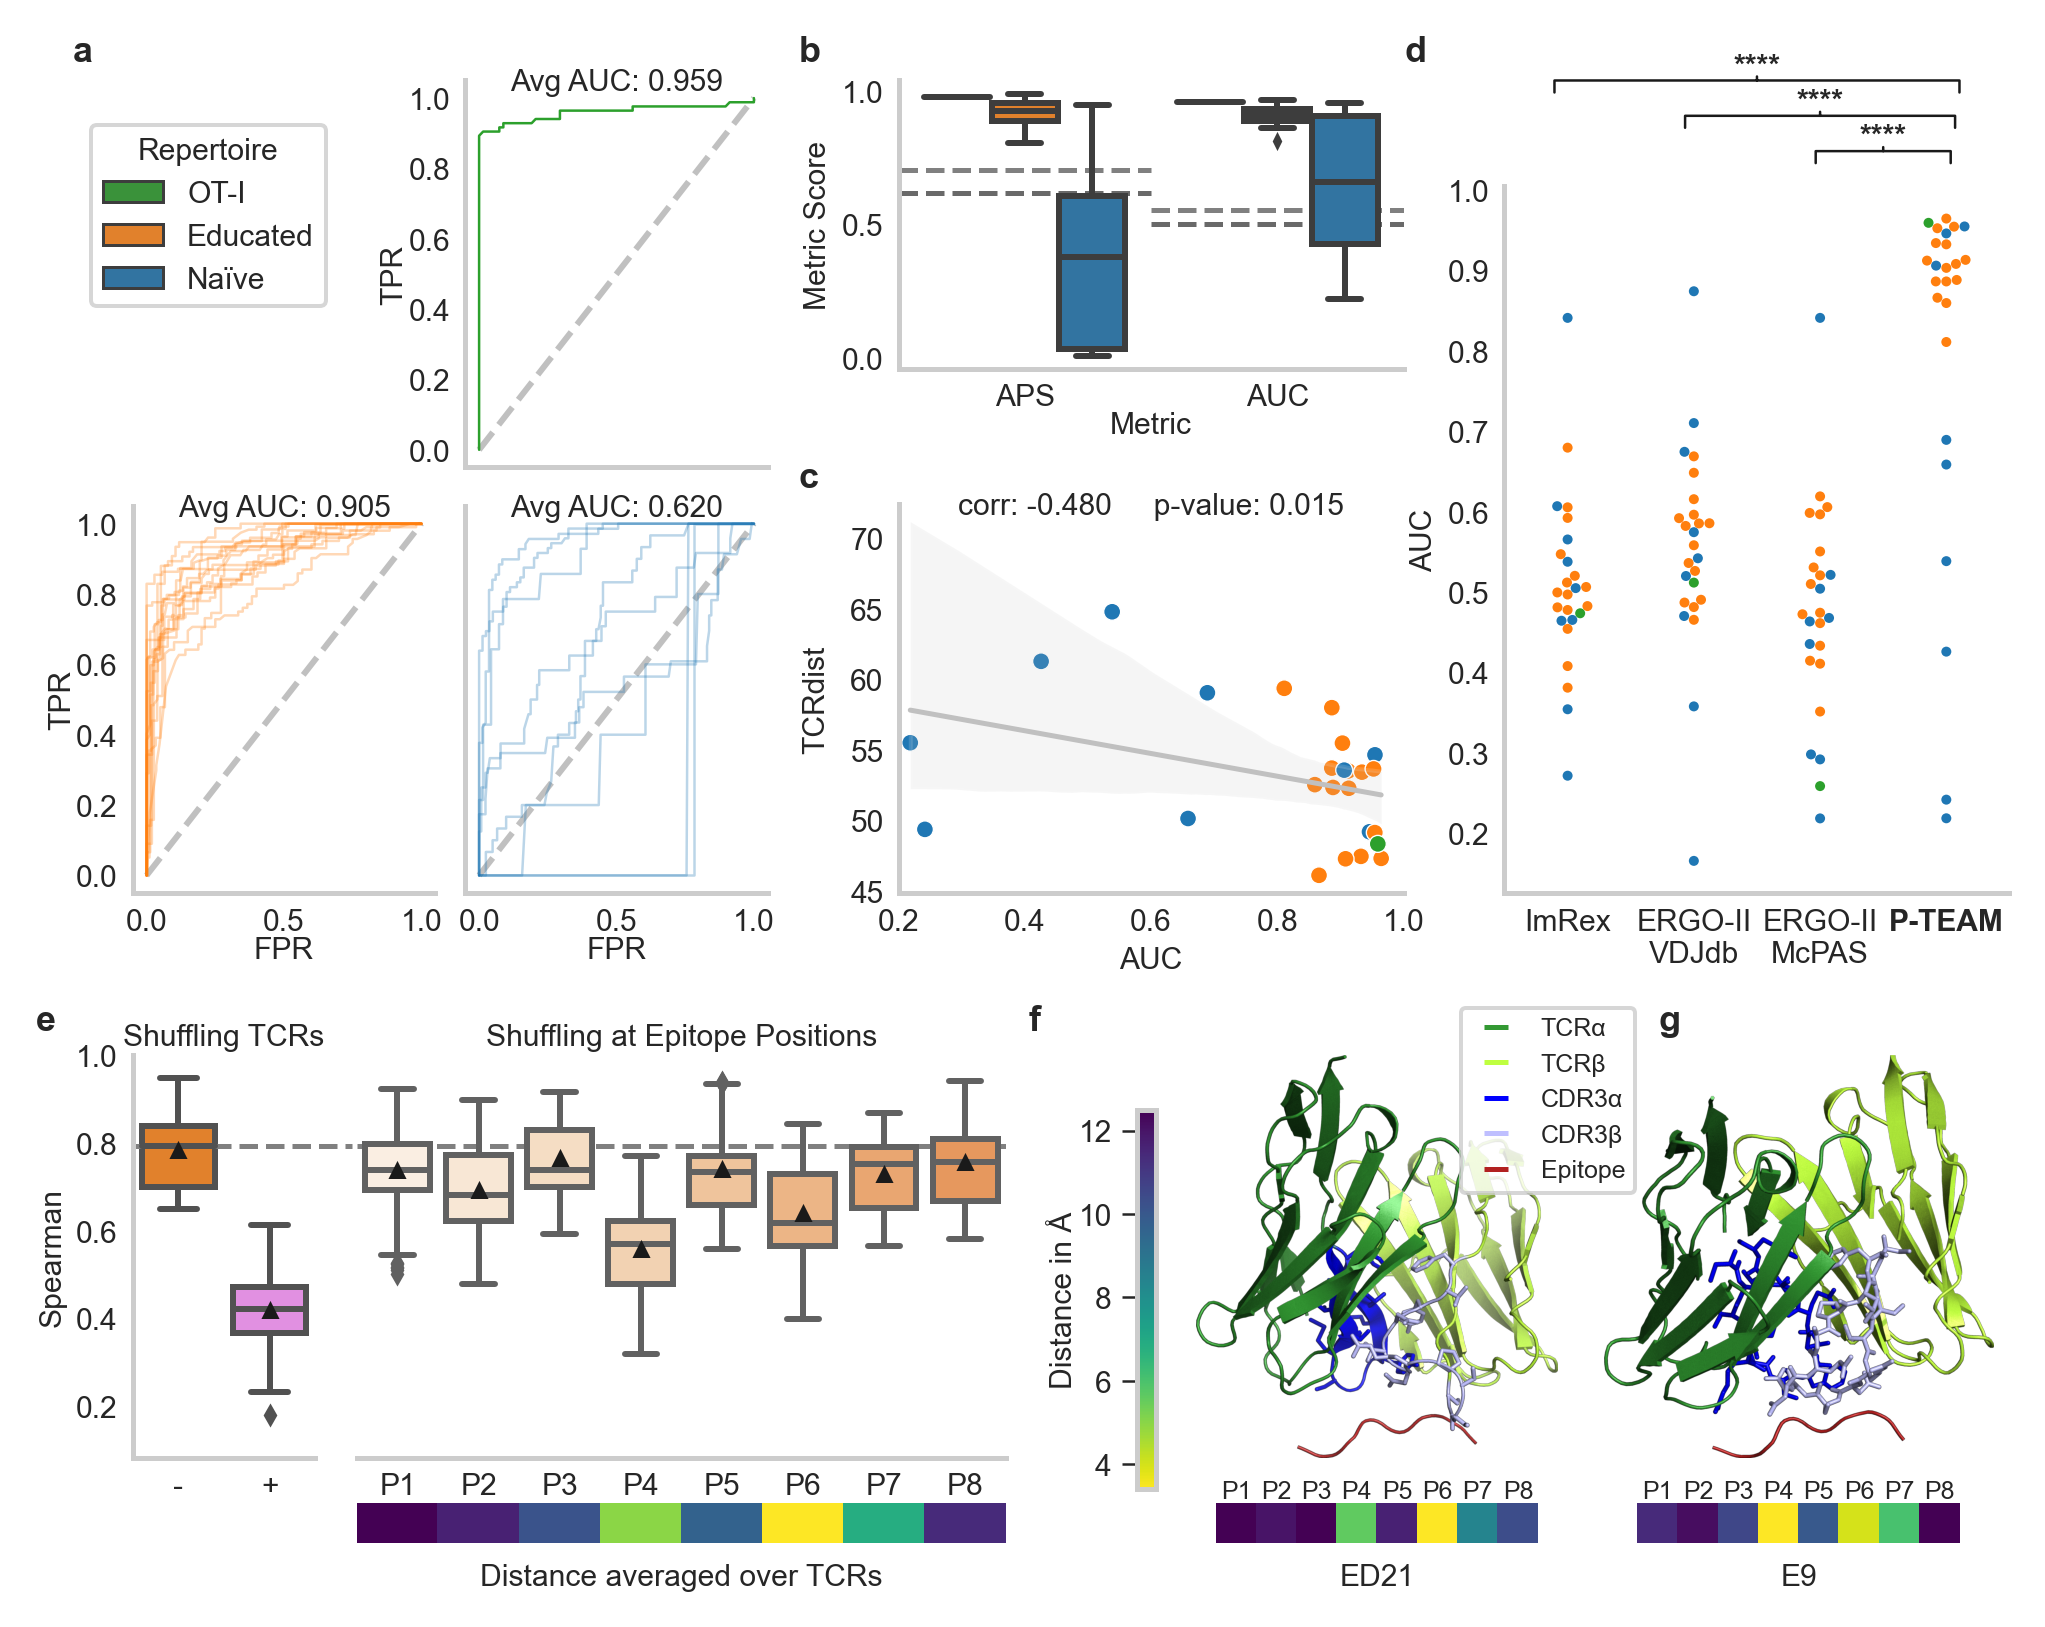

In [45]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.8), dpi=DPI)


gridspecs = {}
axes = {}

gridspecs['gs_1-13'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[0.5, 0.3],
    hspace=0.25,
)

gridspecs['gs_1234'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1-13'][0],
    nrows=1,
    ncols=2,
    width_ratios=[2, 3.5],
    wspace=0.15,
)

gridspecs['gs_1'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1234'][0],
    nrows=2,
    ncols=2,
    height_ratios=[1, 1],
    width_ratios=[1, 1],
    wspace=0.1,
    hspace=0.1
)

gridspecs['gs_234'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1234'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    hspace=0.25
)

gridspecs['gs_23'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_234'][0],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1.35],
    width_ratios=[1],
    #wspace=0.25,
    hspace=0.4
)
#
#gridspecs['gs_34'] = mpl.gridspec.GridSpecFromSubplotSpec(
#    subplot_spec=gridspecs['gs_234'][1],
#    nrows=1,
#    ncols=2,
#    height_ratios=[1],
#    width_ratios=[1, 1],
#    wspace=0.2
#)

gridspecs['gs_4'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_234'][1],
    nrows=2,
    ncols=1,
    height_ratios=[0.15, 1],
    hspace=0
)

for i in range(4):
    axes[f'ax_1_{i}'] = fig.add_subplot(gridspecs['gs_1'][i])
axes['ax_2_tmp'] = fig.add_subplot(gridspecs['gs_23'][0])
axes['ax_2'] = fig.add_subplot(gridspecs['gs_23'][1])
#axes['ax_3'] = fig.add_subplot(gridspecs['gs_234'][1])

axes['ax_4_0'] = fig.add_subplot(gridspecs['gs_4'][0])
axes['ax_4_1'] = fig.add_subplot(gridspecs['gs_4'][1])

axes['ax_1_0'].axis('off')
plot_auc(pdf_classification[pdf_classification['Repertoire']=='OTI'], axes['ax_1_1'], ylabel='TPR')
plot_auc(pdf_classification[pdf_classification['Repertoire']=='Educated'], axes['ax_1_2'], ylabel='TPR', xlabel='FPR')
plot_auc(pdf_classification[pdf_classification['Repertoire']=='Naive'], axes['ax_1_3'], xlabel='FPR')

#plot_naive_test(axes['ax_2'])
#plot_empty(axes['ax_2'])

axes['ax_2_tmp'].axhline(y=df_rdm['AUC'].mean(), xmin=0, xmax=0.5, color='dimgrey', linestyle='--', linewidth=1, zorder=0)
axes['ax_2_tmp'].axhline(y=df_rdm['AUC_ed'].mean(), xmin=0, xmax=0.5, color='gray', linestyle='--', linewidth=1, zorder=0)
axes['ax_2_tmp'].axhline(y=df_rdm['APS'].mean(), xmin=0.5, xmax=1, color='dimgrey', linestyle='--', linewidth=1, zorder=0)
axes['ax_2_tmp'].axhline(y=df_rdm['APS_ed'].mean(), xmin=0.5, xmax=1, color='gray', linestyle='--', linewidth=1, zorder=0)


plot_metric_boxplot(['APS', 'AUC'], axes['ax_2_tmp'])
tcr_dist_vs_metric(axes['ax_2'], aggr='mean')

plot_baseline_data(performance_baseline, axes['ax_4_1'])
plot_significance(axes['ax_4_0'])

plot_tcr_legend([axes['ax_2_tmp']], axes['ax_1_0'], style='center')


# Structural modelling
tcr_mice = ('Ed21', 'E9')
vmin = min([d.min() for d in dists_mice.values()])
vmax = max([d.max() for d in dists_mice.values()])

gridspecs['gs5-13'] = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gridspecs['gs_1-13'][1],
        nrows=1,
        ncols=2,
        width_ratios=[1, 1],
        wspace=0.15
)

gridspecs['gs5-8'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs5-13'][1],
    nrows=1,
    ncols=2,
    width_ratios=[0.15, 1],
    wspace=-0.2,
    #hspace=-0.15
)  

gridspecs['gs6-8'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs5-8'][1],
    nrows=2,
    ncols=2,
    height_ratios=[10, 1],
    width_ratios=[1, 1],
    wspace=-0.0
    #hspace=-0.15
)    
gridspecs['gs9-13'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs5-13'][0],
    nrows=2,
    ncols=2,
    height_ratios=[10, 1],
    width_ratios=[2.25, 8],
    wspace=0.1
)

axes['ax_5'] = fig.add_subplot(gridspecs['gs5-8'][0])
axes['ax_6'] = fig.add_subplot(gridspecs['gs6-8'][0])
axes['ax_7'] = fig.add_subplot(gridspecs['gs6-8'][1])
axes['ax_8'] = fig.add_subplot(gridspecs['gs6-8'][2])
axes['ax_9'] = fig.add_subplot(gridspecs['gs6-8'][3])
axes['ax_10'] = fig.add_subplot(gridspecs['gs9-13'][0])
axes['ax_11'] = fig.add_subplot(gridspecs['gs9-13'][1])
axes['ax_12'] = fig.add_subplot(gridspecs['gs9-13'][2])
axes['ax_13'] = fig.add_subplot(gridspecs['gs9-13'][3])


palette_base = [palette_tcrs['Educated'], color_cdr3]

plot_colorbar(axes['ax_5'], epitope='SIINFEKL', do_legend=False, do_left=True)
plot_3d_structures(axes['ax_7'], tcr_mice[1])
plot_3d_distances(axes['ax_8'], tcr_mice[0])
plot_3d_distances(axes['ax_9'], tcr_mice[1])
plot_3d_structures(axes['ax_6'], tcr_mice[0], do_legend=True)
axes['ax_6'].set_zorder(1)

plot_permutation_importance_base(df_importance_mice, axes['ax_10'], palette_base, do_heading=True)
plot_permutation_importance_position(df_importance_mice, axes['ax_11'], palette=palette_educated, do_heading=True)
axes['ax_12'].axis('off')
plot_3d_distances(axes['ax_13'], 'avg', do_labels=False)

fig.text(0.1, 0.89, 'a', size='large', weight='bold')
fig.text(0.4, 0.89, 'b', size='large', weight='bold')
fig.text(0.4, 0.67, 'c', size='large', weight='bold')
fig.text(0.65, 0.89, 'd', size='large', weight='bold')

fig.text(0.085, 0.39, 'e', size='large', weight='bold')
fig.text(0.495, 0.39, 'f', size='large', weight='bold')
fig.text(0.755, 0.39, 'g', size='large', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_fig3_generalization.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_fig3_generalization.png', dpi=DPI, bbox_inches='tight')

## Suppl. Other metrics

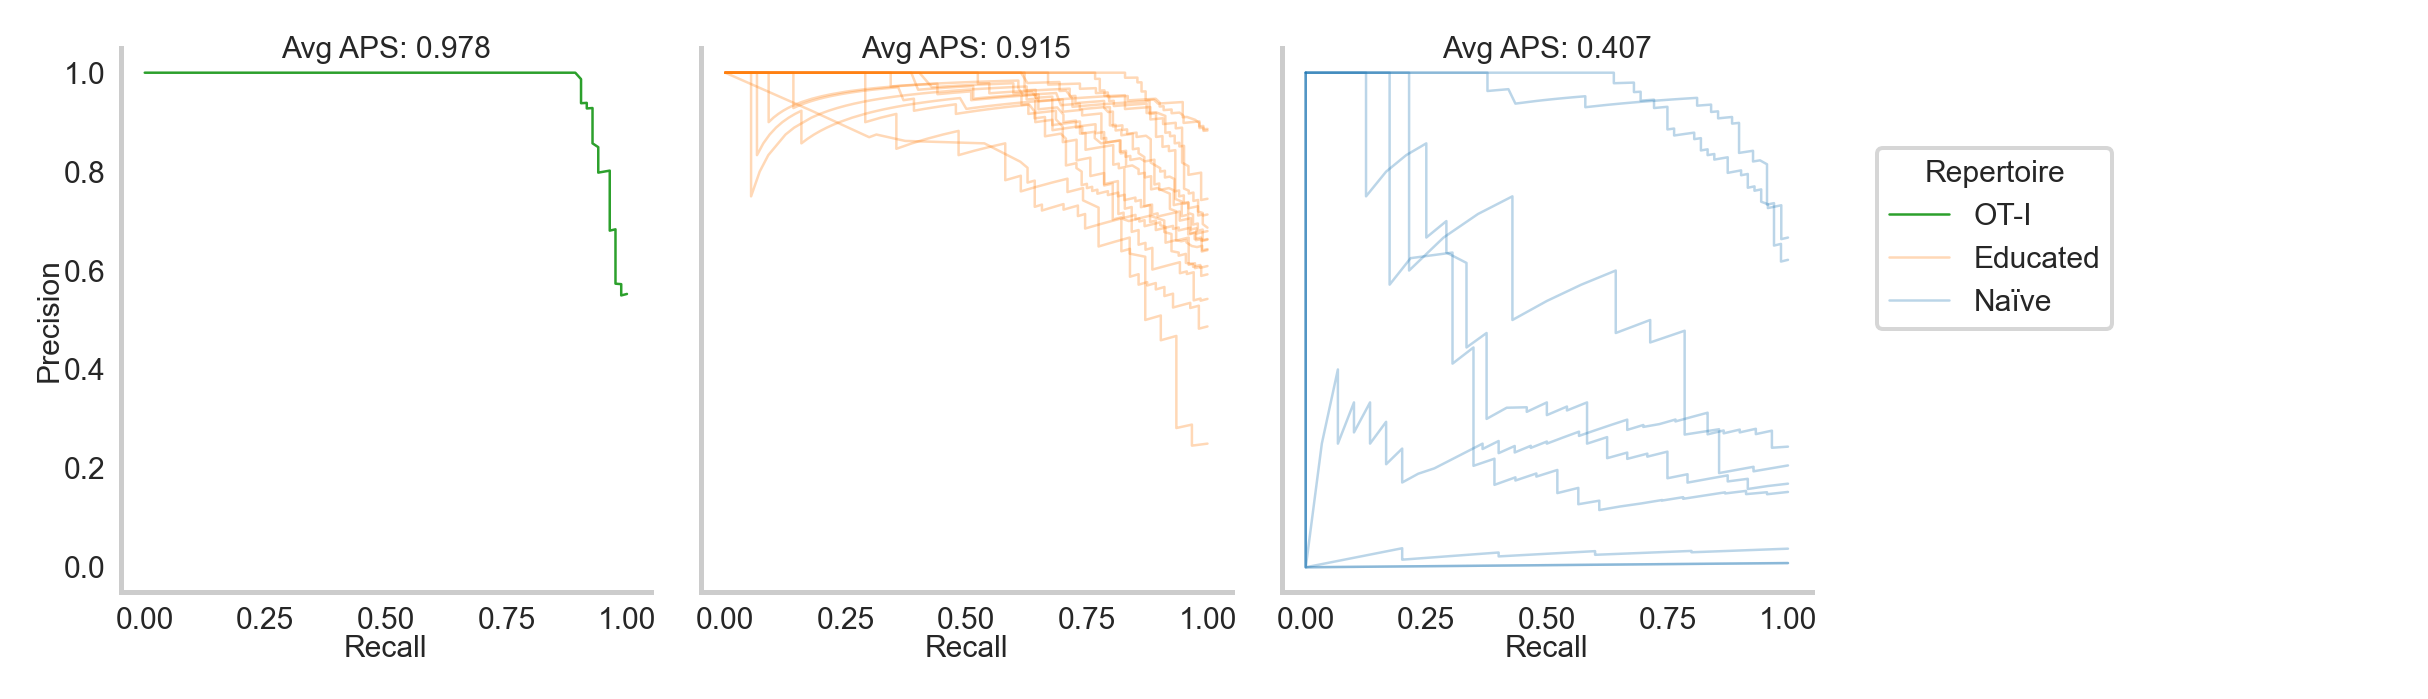

In [46]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH / 3.5), dpi=DPI)


gridspecs = {}
axes = {}

gridspecs['gs_1'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=4,
    width_ratios=[1, 1, 1, 1]
)


for i in range(4):
    axes[f'ax_1_{i}'] = fig.add_subplot(gridspecs['gs_1'][i])

plot_auc(pdf_classification[pdf_classification['Repertoire']=='OTI'], axes['ax_1_0'], ylabel='Precision', xlabel='Recall',
         metric_func=metrics.precision_recall_curve,
         metric_name='APS')
plot_auc(pdf_classification[pdf_classification['Repertoire']=='Educated'], axes['ax_1_1'], xlabel='Recall',
         metric_func=metrics.precision_recall_curve,
         metric_name='APS')
plot_auc(pdf_classification[pdf_classification['Repertoire']=='Naive'], axes['ax_1_2'], xlabel='Recall', 
         metric_func=metrics.precision_recall_curve,
         metric_name='APS')

axes['ax_1_3'].axis('off')

plot_tcr_legend([axes['ax_1_0'], axes['ax_1_1'], axes['ax_1_2']], axes['ax_1_3'])


fig.tight_layout()
fig.savefig('figures/manuscript_supp_acrossMetrics.pdf', dpi=DPI, bbox_inches='tight')

## Suppl. Leave-naive vs Leave-educated-out

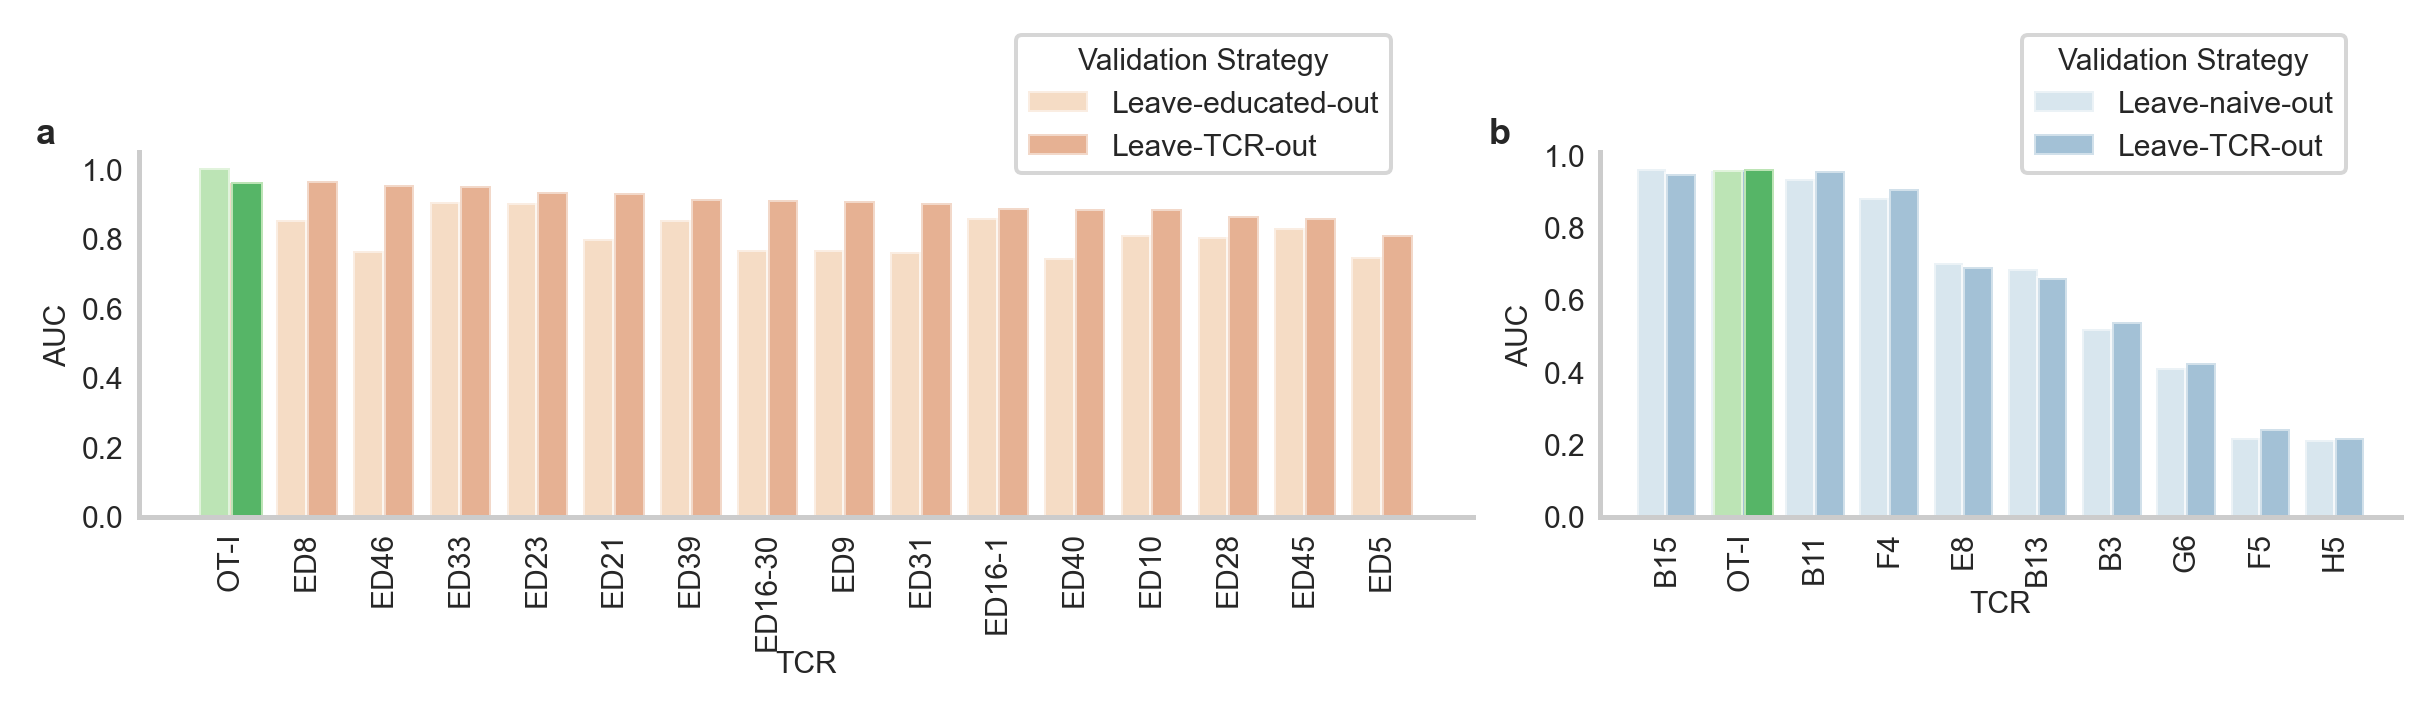

In [47]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH / 3.5), dpi=DPI)


gridspecs = {}
axes = {}

gridspecs['gs_1'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[2, 1.2]
)


axes[f'ax_a'] = fig.add_subplot(gridspecs['gs_1'][0])
axes[f'ax_b'] = fig.add_subplot(gridspecs['gs_1'][1])

plot_naive_test(axes['ax_a'], naive=False)
plot_naive_test(axes['ax_b'], naive=True)

fig.text(0.01, 0.82, 'a', size='large', weight='bold')
fig.text(0.61, 0.82, 'b', size='large', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_supp_cross_prediction.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_cross_prediction.png', dpi=DPI, bbox_inches='tight')

## Statistics for the paper

In [48]:
print('\nauc summary mice\n',
    df_classification_metrics.groupby('Repertoire').describe().T
)

metrics_class_educated = df_classification_metrics[df_classification_metrics['Repertoire']=='Educated']
metrics_class_naive = df_classification_metrics[df_classification_metrics['Repertoire']=='Naive']

print('\nbest edu\n', metrics_class_educated.sort_values('AUC').tail(3))
print('\nworst edu\n', metrics_class_educated.sort_values('AUC').head(3))
print('\nbest naive\n', metrics_class_naive.sort_values('AUC').tail(3))
print('\nworst naive\n', metrics_class_naive.sort_values('AUC').head(3))
print('\nbelow random\n', df_classification_metrics.query('AUC < 0.5').sort_values('AUC'))

print('\ncomparing auc of leave-tcr-out and leave-naive-out\n', stats.ttest_rel(*pd.merge(
     naive_test_data,
     df_classification_metrics,
     left_on='tcr', right_on='tcr',
)[['AUC_x', 'AUC_y']].values.T))


auc summary mice
 Repertoire    Educated      Naive        OTI
index count  15.000000   9.000000   1.000000
      mean   12.000000  10.666667  24.000000
      std     4.472136  10.368221        NaN
      min     5.000000   0.000000  24.000000
      25%     8.500000   2.000000  24.000000
      50%    12.000000   4.000000  24.000000
      75%    15.500000  21.000000  24.000000
      max    19.000000  23.000000  24.000000
AUC   count  15.000000   9.000000   1.000000
      mean    0.904869   0.619929   0.959296
      std     0.040874   0.286169        NaN
      min     0.811051   0.218543   0.959296
      25%     0.886392   0.425850   0.959296
      50%     0.908176   0.658607   0.959296
      75%     0.933335   0.906056   0.959296
      max     0.964591   0.954776   0.959296
APS   count  15.000000   9.000000   1.000000
      mean    0.915238   0.406667   0.977553
      std     0.057166   0.370538        NaN
      min     0.804589   0.008403   0.977553
      25%     0.887234   0.034315   

In [49]:
print('Paired t-test between P-TEAM and baseline models on AUC:')
for col in ['ergo-mcpas', 'ergo-vdjdb', 'imrex']:
    res = stats.ttest_rel(performance_baseline[col], performance_baseline['P-TEAM'])
    print(f'{col}: {res}')
    
print('\nPaired t-test between P-TEAM and baseline models on Spearman:')
for col in ['ergo-mcpas', 'ergo-vdjdb', 'imrex']:
    res = stats.ttest_rel(performance_baseline_regression[col], performance_baseline_regression['P-TEAM'])
    print(f'{col}: {res}')

Paired t-test between P-TEAM and baseline models on AUC:
ergo-mcpas: Ttest_relResult(statistic=-6.507215671946542, pvalue=9.924511706215457e-07)
ergo-vdjdb: Ttest_relResult(statistic=-5.106381102127741, pvalue=3.175371095326685e-05)
imrex: Ttest_relResult(statistic=-5.807037771245438, pvalue=5.486238951708562e-06)

Paired t-test between P-TEAM and baseline models on Spearman:
ergo-mcpas: Ttest_relResult(statistic=-15.196882694426845, pvalue=8.170195872089378e-14)
ergo-vdjdb: Ttest_relResult(statistic=-11.345919458494976, pvalue=3.951991883125002e-11)
imrex: Ttest_relResult(statistic=-14.523011702678522, pvalue=2.1896436829776125e-13)


In [50]:
print('Mean performance of the baseline models (AUC):')
print(performance_baseline.mean())

print('\nPerformance on the murine dataset:')
df_tmp = performance_baseline[~performance_baseline['tcr'].str.startswith('R')]
print(df_tmp.mean())

print('\nPerformance on OTI:')
df_tmp = performance_baseline[performance_baseline['tcr'] == 'OTI']
print(df_tmp.mean())

print('\nPerformance on the educated repertoire:')
df_tmp = performance_baseline[performance_baseline['tcr'].str.startswith('ED')]
print(df_tmp.mean())

print('\nPerformance on the naive repertoire:')
df_tmp = performance_baseline[(~performance_baseline['tcr'].str.startswith('ED')) 
                              & (performance_baseline['tcr']!='OTI')
                              & (~performance_baseline['tcr'].str.startswith('R'))]
print(df_tmp.mean())

Mean performance of the baseline models (AUC):
ergo-mcpas    0.473977
ergo-vdjdb    0.552760
imrex         0.509120
P-TEAM        0.804468
dtype: float64

Performance on the murine dataset:
ergo-mcpas    0.473977
ergo-vdjdb    0.552760
imrex         0.509120
P-TEAM        0.804468
dtype: float64

Performance on OTI:
ergo-mcpas    0.258578
ergo-vdjdb    0.511730
imrex         0.473564
P-TEAM        0.959296
dtype: float64

Performance on the educated repertoire:
ergo-mcpas    0.503300
ergo-vdjdb    0.561236
imrex         0.509557
P-TEAM        0.904869
dtype: float64

Performance on the naive repertoire:
ergo-mcpas    0.449038
ergo-vdjdb    0.543191
imrex         0.512343
P-TEAM        0.619929
dtype: float64


#### Correlating Wildtype activation to performance

In [51]:
df_wildtype = pdf_regression[['tcr', 'wild_activation']].drop_duplicates().reset_index(drop=True).set_index('tcr')
df_wildtype = pd.concat([df_wildtype, 
                         df_classification_metrics[['tcr', 'AUC', 'APS']].set_index('tcr'),
                         df_regression_metrics[['tcr', 'Spearman']].set_index('tcr')], axis=1)
df_wildtype = df_wildtype[~df_wildtype['AUC'].isna()]

print('Both datasets')
for m in ['AUC', 'APS']:
    print(f'  Correlation wildtype activation to {m}: ', stats.pearsonr(df_wildtype['wild_activation'], df_wildtype[m]))

print('Murine datasets')
df_wildtype_murine = df_wildtype[~df_wildtype.index.str.startswith('R')]
for m in ['AUC', 'APS']:
    print(f'  Correlation wildtype activation to {m}: ', stats.pearsonr(df_wildtype_murine['wild_activation'], 
                                                                         df_wildtype_murine[m])) 

Both datasets
  Correlation wildtype activation to AUC:  (0.9114416184767613, 2.409600897893754e-10)
  Correlation wildtype activation to APS:  (0.9805097367544263, 9.333597575197047e-18)
Murine datasets
  Correlation wildtype activation to AUC:  (0.9114416184767613, 2.409600897893754e-10)
  Correlation wildtype activation to APS:  (0.9805097367544263, 9.333597575197047e-18)


## Suppl. Correlations

In [52]:
def plot_correlation(data, x, y, ax, x_label, y_label, do_legend=False):
    def get_repertoire(tcr):
        if tcr == 'OTI':
            return 'OTI'
        if tcr.startswith('ED'):
            return 'Educated'
        return 'Naive'
    data['repertoire'] = [get_repertoire(tcr) for tcr in data.index]
    
    sb.regplot(data=data, x=x, y=y, ax=ax, scatter=False, color=color_mice,
           line_kws={'linewidth':1})
    sb.scatterplot(data=data, x=x, y=y, hue='repertoire', ax=ax, size=3, palette=palette_tcrs)
    
    test = stats.pearsonr(data[x], data[y])
    ax.set_title(f'corr: {test[0]:.3f}     p-value: {test[1]:.1e}', pad=-2, size='medium')
    
    ylim = ax.get_ylim()
    ylim = (ylim[0]-(ylim[1]-ylim[0])*0.025, ylim[1]+(ylim[1]-ylim[0])*0.025)
    ax.set_ylim(ylim)
    
    xlim = ax.get_xlim()
    xlim = (xlim[0]-(xlim[1]-xlim[0])*0.025, xlim[1]+(xlim[1]-xlim[0])*0.025)
    ax.set_xlim(xlim)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    

    ax.get_legend().remove()
    if do_legend:
        ax.legend([
            mpl.lines.Line2D([], [], color=palette_tcrs['OTI'], marker='o', linestyle='None', markersize=3),
            mpl.lines.Line2D([], [], color=palette_tcrs['Educated'], marker='o', linestyle='None', markersize=3),
            mpl.lines.Line2D([], [], color=palette_tcrs['Naïve'], marker='o', linestyle='None', markersize=3),
        ], ['OT-I', 'Educated', 'Naïve'], 
        ncol=1, bbox_to_anchor=(1.4, 0.5), loc='center right')
    sb.despine(ax=ax)
    ax.grid(False) 

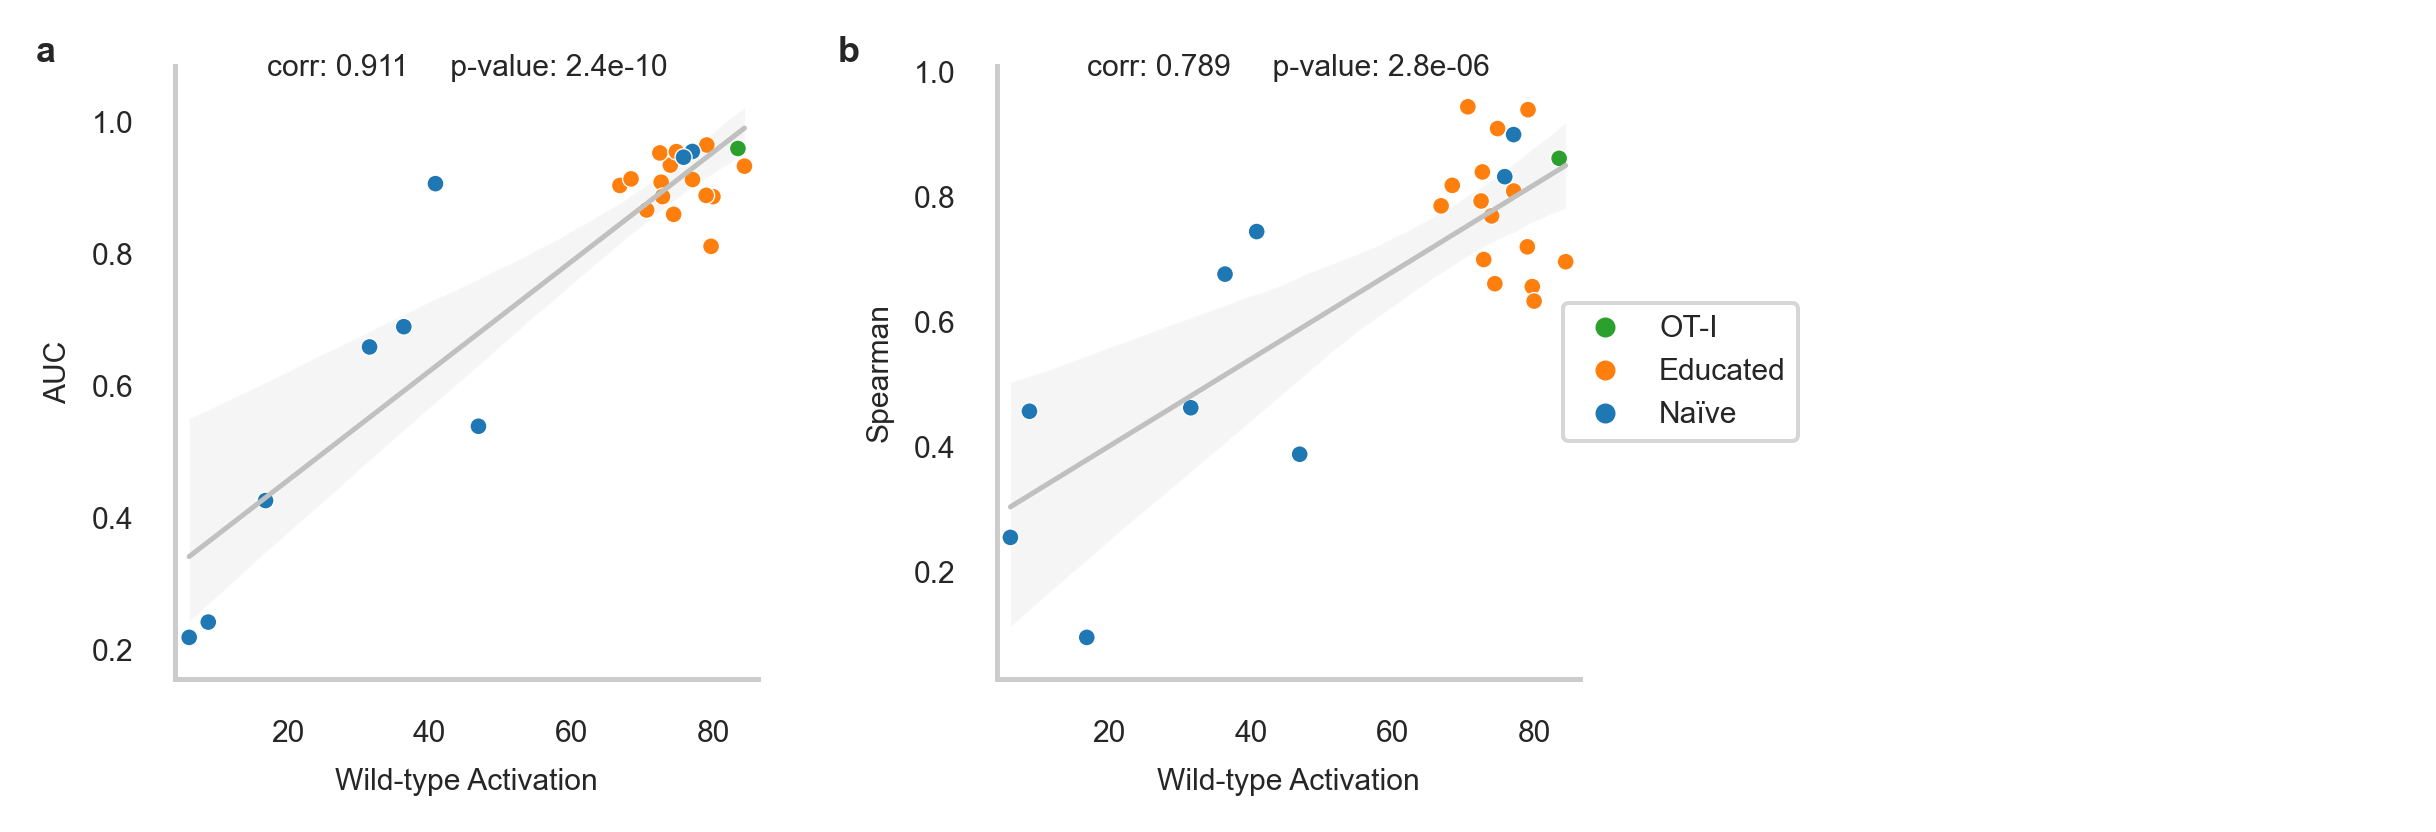

In [53]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH / 3), dpi=DPI)


gridspecs = {}
axes = {}

gridspecs['gs_12'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=3,
    width_ratios=[1, 1, 1],
)

axes['a'] = fig.add_subplot(gridspecs['gs_12'][0])
axes['b'] = fig.add_subplot(gridspecs['gs_12'][1])
axes['c'] = fig.add_subplot(gridspecs['gs_12'][2])

plot_correlation(df_wildtype_murine, 'wild_activation', y='AUC', ax=axes['a'],
                x_label='Wild-type Activation', y_label='AUC')
plot_correlation(df_wildtype_murine, 'wild_activation', y='Spearman', ax=axes['b'],
                x_label='Wild-type Activation', y_label='Spearman', do_legend=True)

axes['c'].axis('off')

fig.text(0.01, 0.95, 'a', size='large', weight='bold')
fig.text(0.341, 0.95, 'b', size='large', weight='bold')


fig.tight_layout()
fig.savefig('figures/manuscript_supp_correlationPerfWildtype.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_correlationPerfWildtype.png', dpi=DPI, bbox_inches='tight')

#### Naive vs TCR out

In [54]:
metric = 'AUC'
dd = pd.merge(naive_test_data, df_classification_metrics, left_on='tcr', right_on='tcr')
dd = dd.rename(columns={f'{metric}_x': 'Leave-naive-out',
                        f'{metric}_y': 'Leave-TCR-out',
                        'tcr': 'TCR',})[['TCR', 'Leave-naive-out', 'Leave-TCR-out']]
dd['Perfomance_difference'] = (dd['Leave-naive-out'] - dd['Leave-TCR-out']).abs()
print(dd['Perfomance_difference'].max())
print(dd['Perfomance_difference'].mean())
dd

0.024863387978142026
0.016752803380389692


TCR  Leave-naive-out  Leave-TCR-out  Perfomance_difference
0  B11         0.931989       0.954776               0.022787
1  B13         0.683470       0.658607               0.024863
2  B15         0.960417       0.946094               0.014323
3   B3         0.517695       0.538423               0.020728
4   E8         0.699707       0.689290               0.010417
5   F4         0.881470       0.906056               0.024586
6   F5         0.218543       0.241722               0.023179
7   G6         0.410204       0.425850               0.015646
8   H5         0.211921       0.218543               0.006623
9  OTI         0.954919       0.959296               0.004377

In [55]:
metric = 'AUC'
dd = pd.merge(educated_test_data, df_classification_metrics, left_on='tcr', right_on='tcr')
dd = dd.rename(columns={f'{metric}_x': 'Leave-naive-out',
                        f'{metric}_y': 'Leave-TCR-out',
                        'tcr': 'TCR',})[['TCR', 'Leave-naive-out', 'Leave-TCR-out']]
dd['Perfomance_difference'] = (dd['Leave-naive-out'] - dd['Leave-TCR-out']).abs()
print(dd['Perfomance_difference'].max())
print(dd['Perfomance_difference'].mean())
dd

0.19021645021645017
0.09027117521546092


TCR  Leave-naive-out  Leave-TCR-out  Perfomance_difference
0      ED10         0.811373       0.886373               0.075000
1    ED16-1         0.859328       0.888240               0.028912
2   ED16-30         0.768139       0.912294               0.144156
3      ED21         0.797654       0.932551               0.134897
4      ED23         0.902021       0.934119               0.032098
5      ED28         0.804917       0.866111               0.061194
6      ED31         0.762463       0.903274               0.140811
7      ED33         0.904086       0.952562               0.048476
8      ED39         0.852573       0.913223               0.060650
9      ED40         0.745035       0.886411               0.141376
10     ED45         0.830865       0.859519               0.028654
11     ED46         0.764329       0.954545               0.190216
12      ED5         0.746196       0.811051               0.064855
13      ED8         0.852747       0.964591               0.111844
14      ED9         0.767682       0.908176               0.140494
15      OTI         1.000000       0.959296               0.040704

### Metrics

In [56]:
df_classification_metrics[['tcr', 'AUC', 'APS']].sort_values('tcr').round(3)

tcr    AUC    APS
0       B11  0.955  0.945
1       B13  0.659  0.275
2       B15  0.946  0.947
3        B3  0.538  0.379
4        E8  0.689  0.456
5      ED10  0.886  0.945
6    ED16-1  0.888  0.928
7   ED16-30  0.912  0.925
8      ED21  0.933  0.982
9      ED23  0.934  0.973
10     ED28  0.866  0.807
11     ED31  0.903  0.859
12     ED33  0.953  0.923
13     ED39  0.913  0.805
14     ED40  0.886  0.895
15     ED45  0.860  0.919
16     ED46  0.955  0.960
17      ED5  0.811  0.880
18      ED8  0.965  0.990
19      ED9  0.908  0.938
20       F4  0.906  0.608
21       F5  0.242  0.009
22       G6  0.426  0.034
23       H5  0.219  0.008
24      OTI  0.959  0.978

In [57]:
df_regression_metrics[['tcr', 'Spearman']].sort_values('tcr').round(3).sort_values('Spearman')

tcr  Spearman
24       G6     0.095
2       B14     0.129
4        B2     0.246
25       H5     0.255
5        B3     0.388
23       F5     0.457
1       B13     0.462
7      ED10     0.633
26       H6     0.636
19      ED5     0.656
17     ED45     0.661
6        E8     0.676
10     ED21     0.696
16     ED40     0.700
8    ED16-1     0.720
22       F4     0.744
11     ED23     0.769
13     ED31     0.785
14     ED33     0.793
9   ED16-30     0.809
15     ED39     0.818
3       B15     0.832
21      ED9     0.840
27      OTI     0.861
0       B11     0.899
18     ED46     0.909
20      ED8     0.939
12     ED28     0.944

# Supplement Structures

<ipython-input-58-5df19d71b760>:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


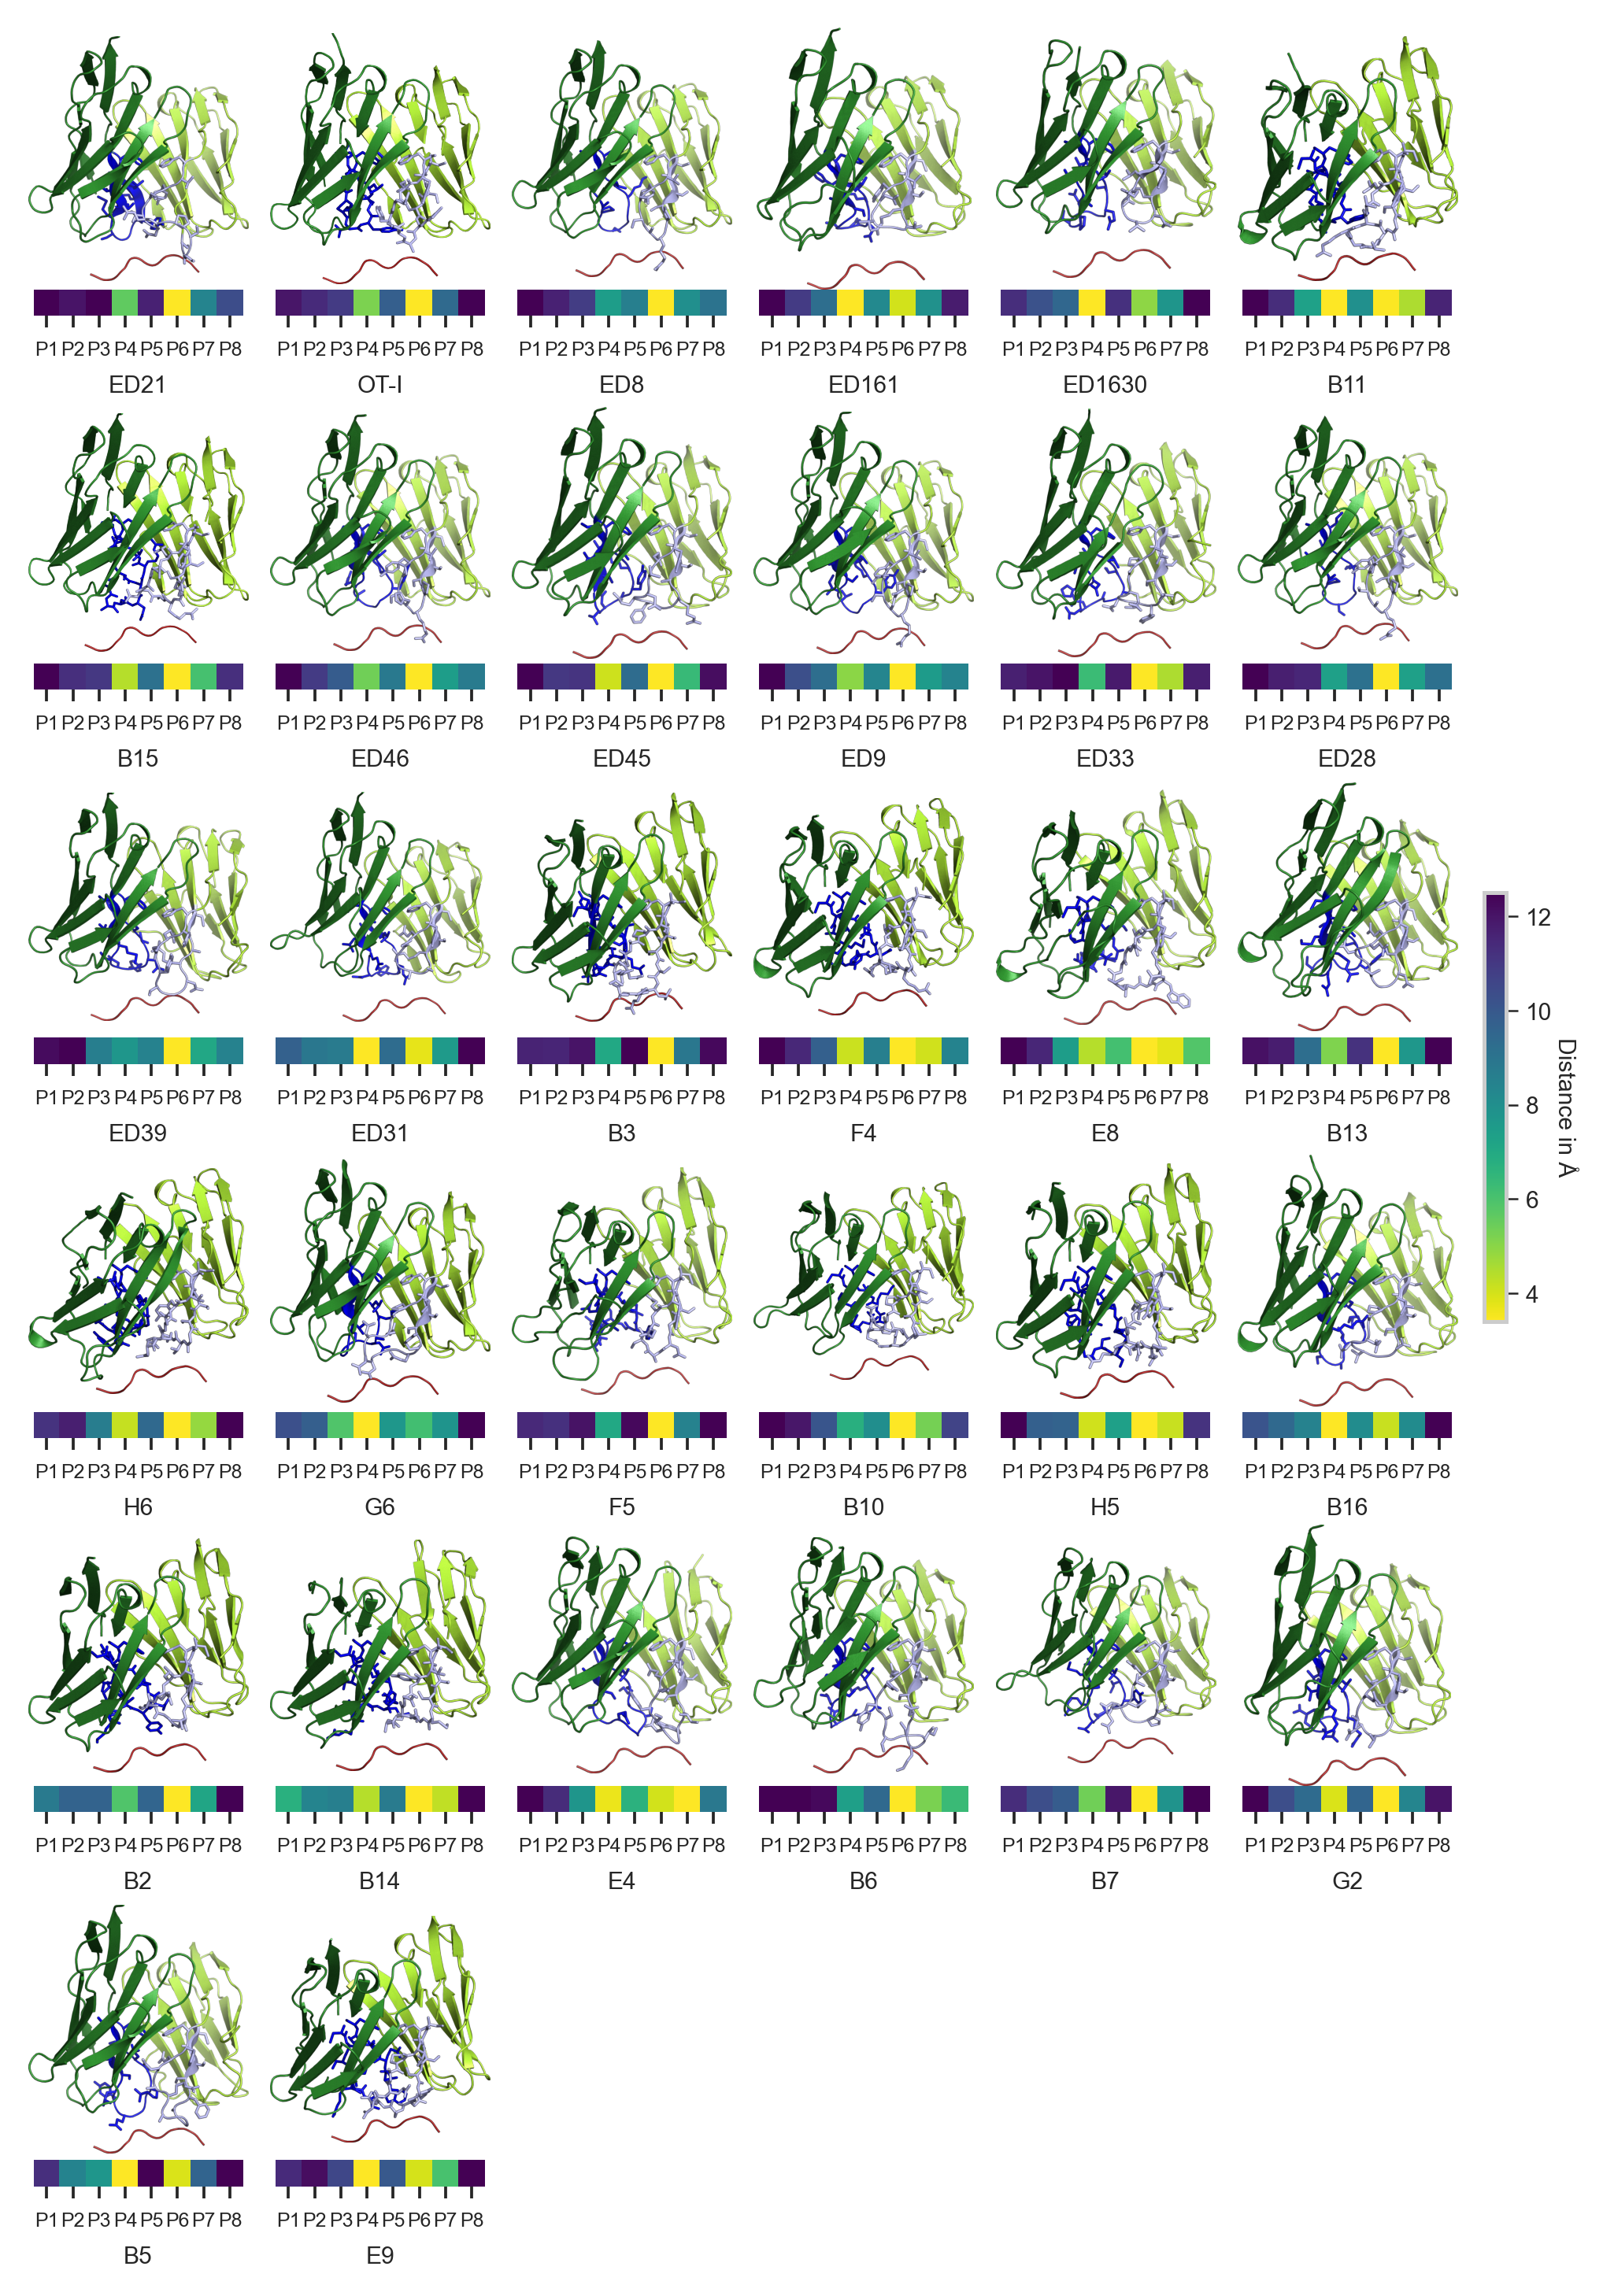

In [58]:
n_cols = 6
n_rows = (len(vis_names_mice)-1)//6 + 1

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.25 * n_rows), dpi=DPI)
gridspecs = {}
axes = {}


gs = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[10, 1],
    wspace=-0.12,
)

gs_vis = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[0],
    nrows=n_rows,
    ncols=n_cols,
    height_ratios=[1]*n_rows,
    width_ratios=[1] * n_cols,
    wspace=0.1,
    hspace=0.3 # 0.2
)

ax_cb = fig.add_subplot(gs[1])
plot_colorbar(ax_cb, 'SIINFEKL')

# Sorted by reactivity to SIINFEKL
vis_names_mice = [
    'Ed21', 'OT1', 'Ed8', 'Ed161', 'Ed1630', 'B11',
    'B15', 'Ed46', 'Ed45', 'Ed9', 'Ed33', 'Ed28', 'Ed39',
    'Ed31', 'B3', 'F4', 'E8', 'B13', 'H6', 'G6', 'F5', 'B10', 'H5', 'B16',
    'B2', 'B14', 'E4', 'B6', 'B7', 'G2', 'B5', 'E9']

for i, tcr in enumerate(vis_names_mice):
    row = i//n_cols
    col = i%n_cols
    gs_tcr = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gs_vis[i],
        nrows=2,
        ncols=1,
        height_ratios=[1, 0.1],
        hspace=-0.
    )
    ax_struc = fig.add_subplot(gs_tcr[0])
    plot_3d_structures(ax_struc, tcr)
    
    ax_dists = fig.add_subplot(gs_tcr[1])
    plot_3d_distances(ax_dists, tcr, legend_top=False)
    
    #fig.text(0.125 + 0.127*col, 0.87-row*0.129, abc[i], size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_supp_3dModelMice.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_3dModelMice.png', dpi=DPI, bbox_inches='tight')

## Figure S6c

In [59]:
palette_pos = sb.color_palette('Set2', 9)#[2:]
palette_pos = sb.color_palette('bright', 9)#[2:]
for i, color in enumerate(palette_pos):
    print(f'set_color P{i+1}, {color}'.replace('(', '[').replace(')', ']'))
    print(f'color P{i+1}, P{i+1}')

set_color P1, [0.00784313725490196, 0.24313725490196078, 1.0]
color P1, P1
set_color P2, [1.0, 0.48627450980392156, 0.0]
color P2, P2
set_color P3, [0.10196078431372549, 0.788235294117647, 0.2196078431372549]
color P3, P3
set_color P4, [0.9098039215686274, 0.0, 0.043137254901960784]
color P4, P4
set_color P5, [0.5450980392156862, 0.16862745098039217, 0.8862745098039215]
color P5, P5
set_color P6, [0.6235294117647059, 0.2823529411764706, 0.0]
color P6, P6
set_color P7, [0.9450980392156862, 0.2980392156862745, 0.7568627450980392]
color P7, P7
set_color P8, [0.6392156862745098, 0.6392156862745098, 0.6392156862745098]
color P8, P8
set_color P9, [1.0, 0.7686274509803922, 0.0]
color P9, P9


In [60]:
def plot_pos_legend(ax):
    ax.legend([mpl.lines.Line2D([], [], color=c, marker='o', linestyle='None', markersize=3)
           for c in palette_pos], 
           [f'P{i+1}' for i, _ in enumerate(palette_pos)], 
    ncol=1, bbox_to_anchor=(0.8, 0.5), loc='center right', title='Eptiope\nPosition')

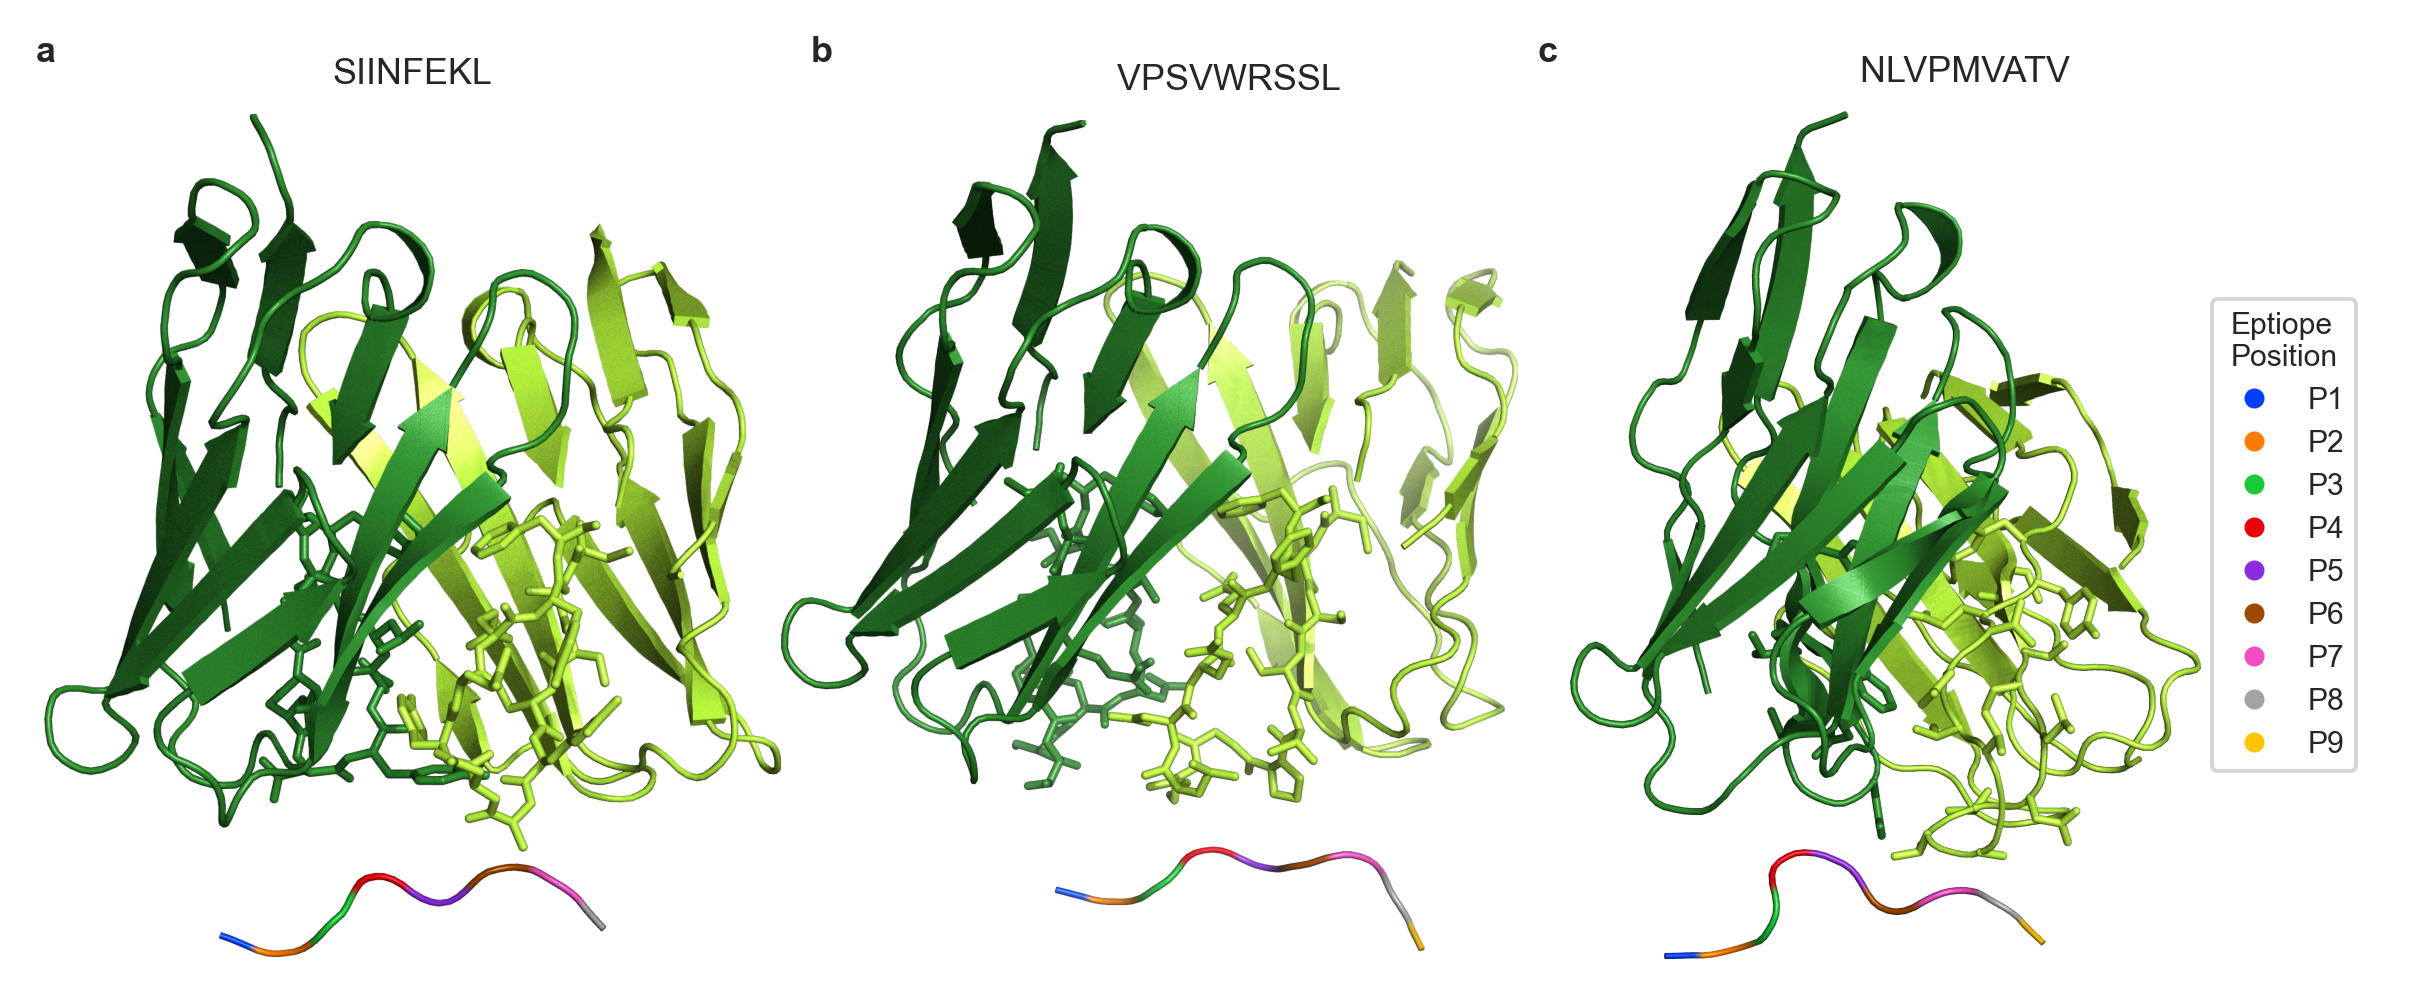

In [61]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.4), dpi=DPI)
gridspecs = {}
axes = {}


gs = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=4,
    width_ratios=[1, 1, 1, 0.2],
    wspace=0.0,
)

ax_a = fig.add_subplot(gs[0])
ax_b = fig.add_subplot(gs[1])
ax_c = fig.add_subplot(gs[2])
ax_d = fig.add_subplot(gs[3])

ax_d.axis('off')


plot_3d_structures(ax_a, 'OT1_pos')
ax_a.set_title('SIINFEKL', size='large')

plot_3d_structures(ax_b, 'R25_pos')
ax_b.set_title('\t\tVPSVWRSSL'.expandtabs(), size='large')

plot_3d_structures(ax_c, 'TCR1-4_position')
ax_c.set_title('\t\tNLVPMVATV'.expandtabs(), size='large')

plot_pos_legend(ax_d)

fig.text(0.01, 0.96, 'a', size='large', weight='bold')
fig.text(0.33, 0.96, 'b', size='large', weight='bold')
fig.text(0.63, 0.96, 'c', size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_supp_3dPositions.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_3dPositions.png', dpi=DPI, bbox_inches='tight')

# Stats for paper

In [62]:
dists_mice_avg = np.vstack([dist for tcr, dist in dists_mice.items()]).mean(axis=0)
dists_mice_avg = pd.DataFrame(data=dists_mice_avg, index=[f'P{i+1}' for i in range(8)], columns=['distance'])

df_importance_mice_avg = df_importance_mice.groupby(['Permutation']).mean().sort_values('Spearman')
df_importance_mice_avg = pd.concat([df_importance_mice_avg, dists_mice_avg], axis=1)
df_importance_mice_avg

Spearman      base      diff       rel  distance
CDR3  0.416327  0.782187 -0.365860 -0.462863       NaN
P4    0.556520  0.782187 -0.225667 -0.289283  5.512574
P6    0.638984  0.782187 -0.143203 -0.183001  4.608275
P2    0.690250  0.782187 -0.091936 -0.119772  9.313581
P7    0.726645  0.782187 -0.055542 -0.068421  6.589564
P1    0.737050  0.782187 -0.045136 -0.055762  9.795427
P5    0.738390  0.782187 -0.043797 -0.055707  8.192974
P8    0.755449  0.782187 -0.026738 -0.035098  9.180278
P3    0.763425  0.782187 -0.018762 -0.021700  8.462829
-     0.782187  0.782187  0.000000  0.000000       NaN

In [63]:
print('Mice: correlation and p-value between Spearman and distance')
df_mice_pos = df_importance_mice_avg[df_importance_mice_avg.index.str.startswith('P')]
stats.pearsonr(df_mice_pos['Spearman'], df_mice_pos['distance'])

Mice: correlation and p-value between Spearman and distance


(0.722411490270147, 0.0429594202899804)

## Correlation

In [64]:
def plot_correlation(data, x, y, ax, x_label, y_label, do_legend=False):
    palette_pos = sb.color_palette('bright', 9)[:-1]
    palette_pos = dict(zip([f'P{i}' for i in range(1, 9)], palette_pos))
    data['position'] = data.index
    
    sb.regplot(data=data, x=x, y=y, ax=ax, scatter=False, color=color_mice,
           line_kws={'linewidth':1})
    sb.scatterplot(data=data, x=x, y=y, hue='position', ax=ax, size=3, palette=palette_pos)
    
    test = stats.pearsonr(data[x], data[y])
    ax.set_title(f'corr: {test[0]:.3f}     p-value: {test[1]:.1e}', pad=-2, size='medium')
    
    ylim = ax.get_ylim()
    ylim = (ylim[0]-(ylim[1]-ylim[0])*0.025, ylim[1]+(ylim[1]-ylim[0])*0.025)
    ax.set_ylim(ylim)
    
    xlim = ax.get_xlim()
    xlim = (xlim[0]-(xlim[1]-xlim[0])*0.025, xlim[1]+(xlim[1]-xlim[0])*0.025)
    ax.set_xlim(xlim)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    

    ax.get_legend().remove()
    if do_legend:
        ax.legend([mpl.lines.Line2D([], [], color=c, marker='o', linestyle='None', markersize=3)
                   for c in palette_pos.values()], 
                   palette_pos.keys(), 
        ncol=1, bbox_to_anchor=(1.3, 0.5), loc='center right', title='Position')
    sb.despine(ax=ax)
    ax.grid(False) 

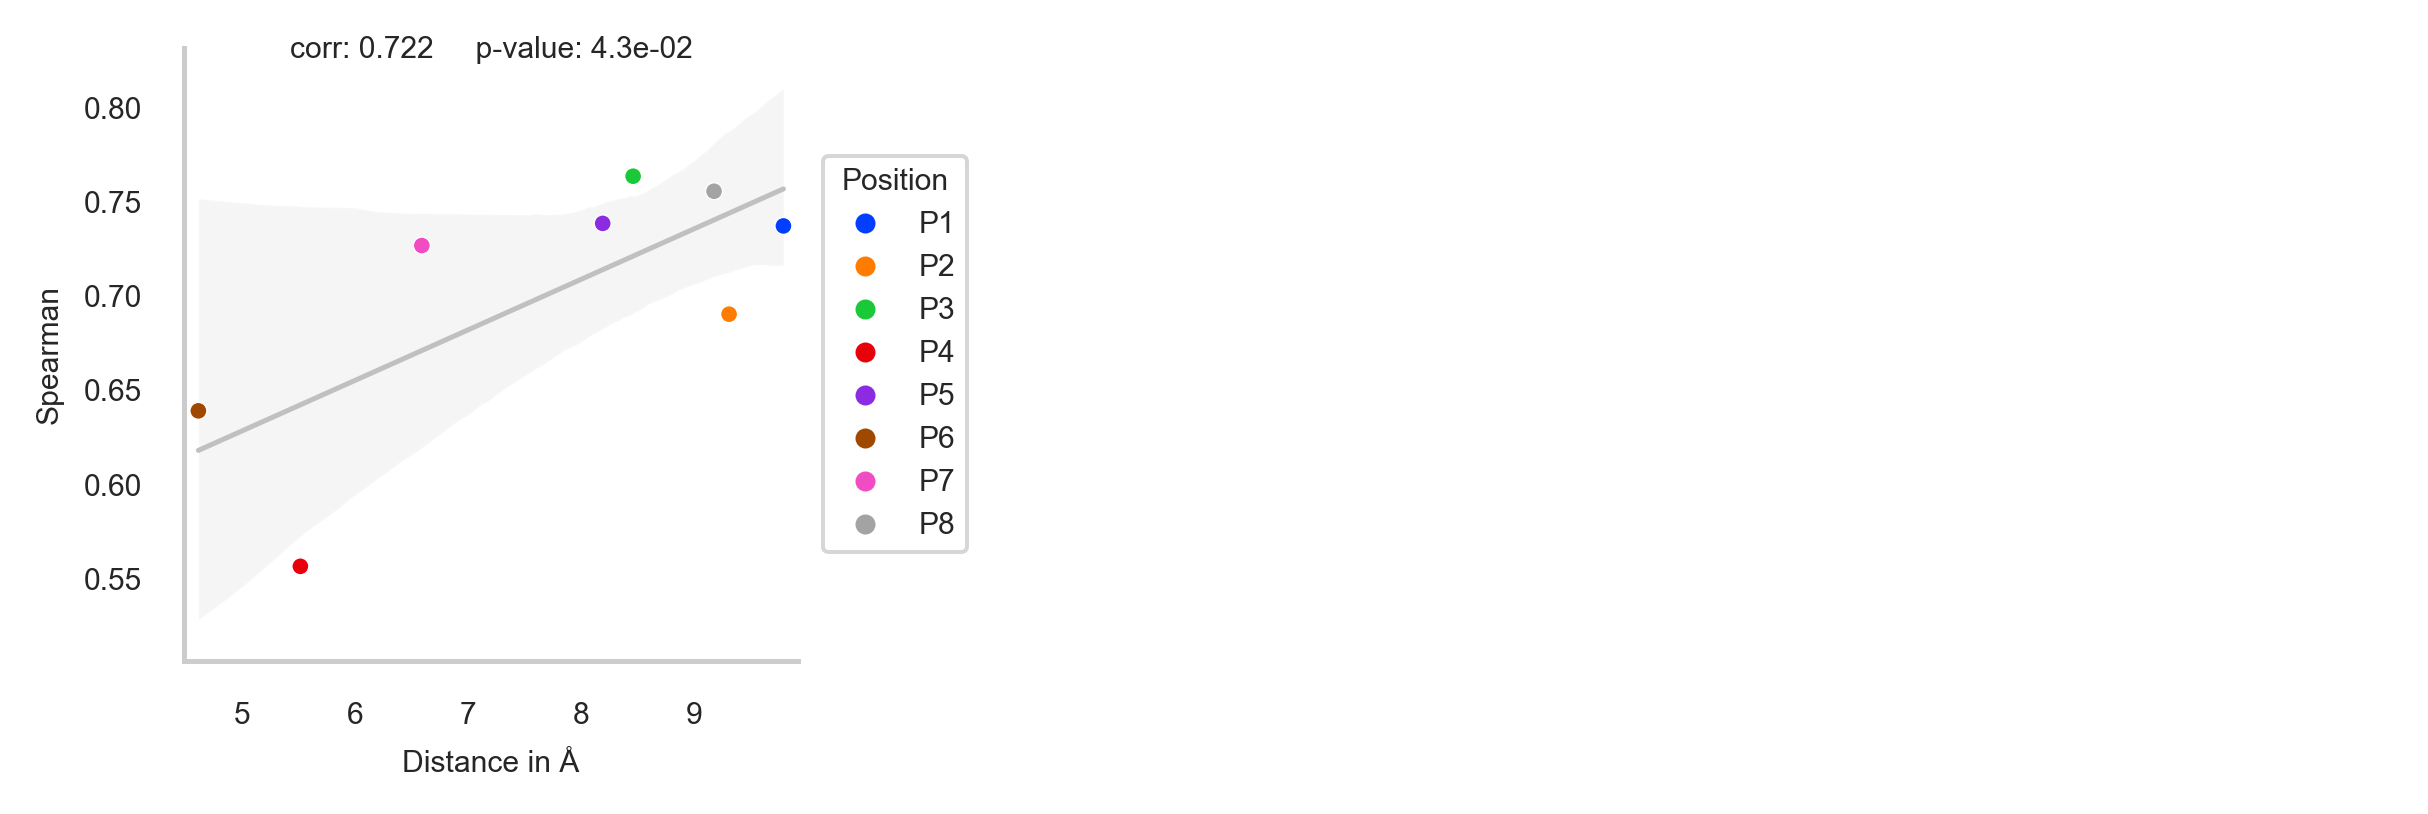

In [65]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH / 3), dpi=DPI)


gridspecs = {}
axes = {}

gridspecs['gs_12'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=3,
    width_ratios=[1, 1, 1],
)

axes['a'] = fig.add_subplot(gridspecs['gs_12'][0])
axes['b'] = fig.add_subplot(gridspecs['gs_12'][1])
axes['c'] = fig.add_subplot(gridspecs['gs_12'][2])

plot_correlation(df_importance_mice_avg.loc[[el for el in df_importance_mice_avg.index if el.startswith('P')]], 
                 x='distance', y='Spearman', ax=axes['a'],
                 x_label='Distance in Å', y_label='Spearman',
                 do_legend=True)

axes['b'].axis('off')
axes['c'].axis('off')

#fig.text(0.01, 0.95, 'a', size='large', weight='bold')


fig.tight_layout()
fig.savefig('figures/manuscript_supp_correlationDistance.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_correlationDistance.png', dpi=DPI, bbox_inches='tight')

## Class on Reg

In [66]:
pdf_classification['abserr'] = 0
df_regbin_metrics = pdf_classification.groupby(['tcr'], as_index=False).apply(compute_regression_metrics).reset_index()
df_regbin_metrics['Repertoire'] = df_regbin_metrics['tcr'].apply(assign_repertoire)
df_regbin_metrics['Train_classification'] = True
df_regression_metrics['Train_classification'] = False
df_regbin_metrics = pd.concat([df_regbin_metrics, df_regression_metrics])
df_regbin_metrics.groupby(['Train_classification', 'Repertoire'])['Spearman'].mean()

Train_classification  Repertoire
False                 Educated      0.778146
                      Naive         0.485037
                      OTI           0.861392
True                  Educated      0.761696
                      Naive         0.520927
                      OTI           0.818213
Name: Spearman, dtype: float64

Text(0.5, 0.98, 'Regression Metrics')

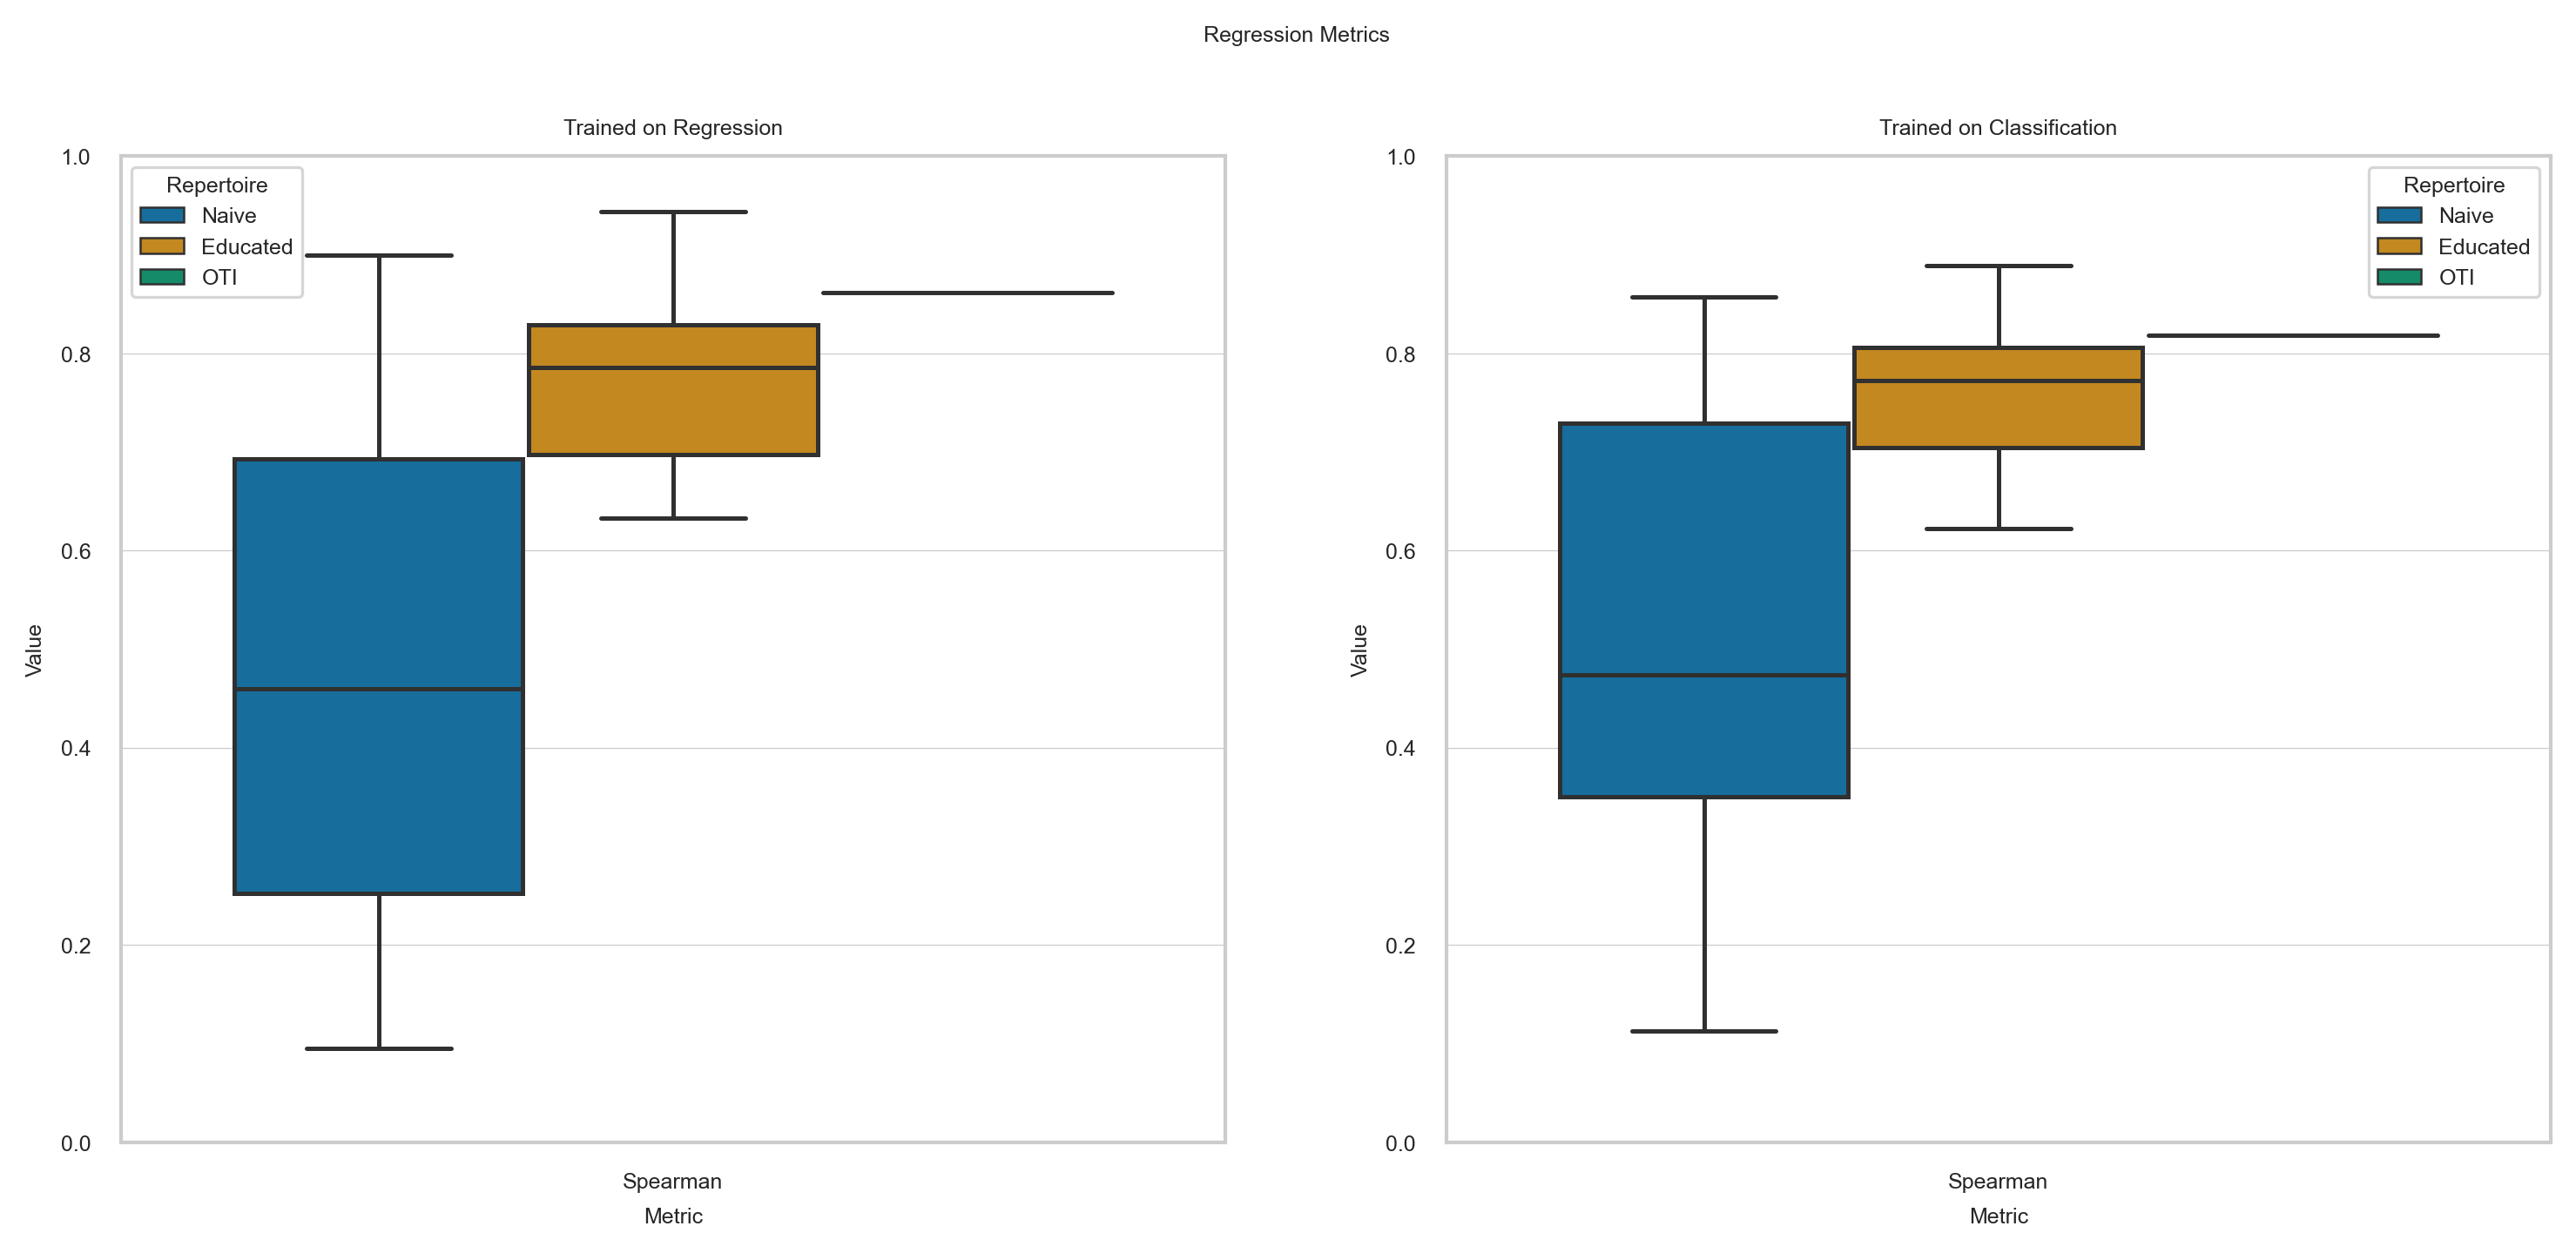

In [67]:
df_plot = df_regbin_metrics[['tcr', 'Repertoire', 'Train_classification', 'Spearman']].copy()
df_plot = df_plot.melt(['tcr', 'Repertoire', 'Train_classification'], value_name='Value', var_name='Metric')

fig = plt.figure(figsize=(12,  5), dpi=300)
gridspecs = {}
axes = {}

gridspecs['gs_1-2'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    #wspace=0.1,
    hspace=0.25,
)

ax_false = fig.add_subplot(gridspecs['gs_1-2'][0])
ax_true = fig.add_subplot(gridspecs['gs_1-2'][1])
sb.boxplot(data=df_plot[df_plot['Train_classification']], x='Metric', y='Value', hue='Repertoire', ax=ax_true)
sb.boxplot(data=df_plot[~df_plot['Train_classification']], x='Metric', y='Value', hue='Repertoire', ax=ax_false)
ax_false.set_ylim(0, 1)
ax_false.set_title('Trained on Regression')
ax_true.set_ylim(0, 1)
ax_true.set_title('Trained on Classification')
fig.suptitle('Regression Metrics')

## Heatmap

In [68]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data_mice_norm.transpose())
embedding = pd.DataFrame(data=embedding, index=data_mice_norm.columns, columns=['UMAP_1', 'UMAP_2'])
embedding['Repertoire'] = embedding.index.map(assign_repertoire)
embedding['tcr'] = embedding.index

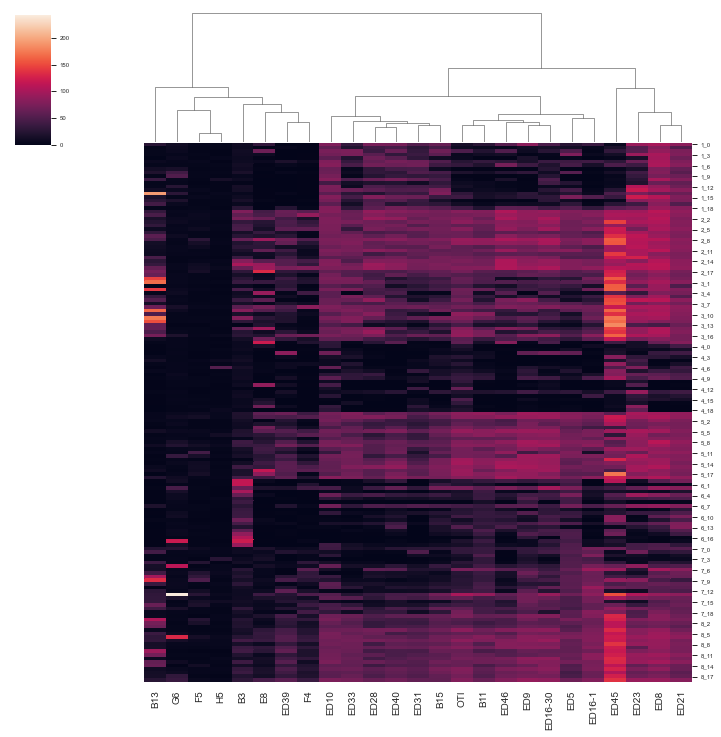

In [69]:
plot = sb.clustermap(data_mice_norm, row_cluster=False, col_cluster=True, method='ward')
plot.ax_heatmap.tick_params(axis='x', labelsize=10)
# average, single, ward, complete

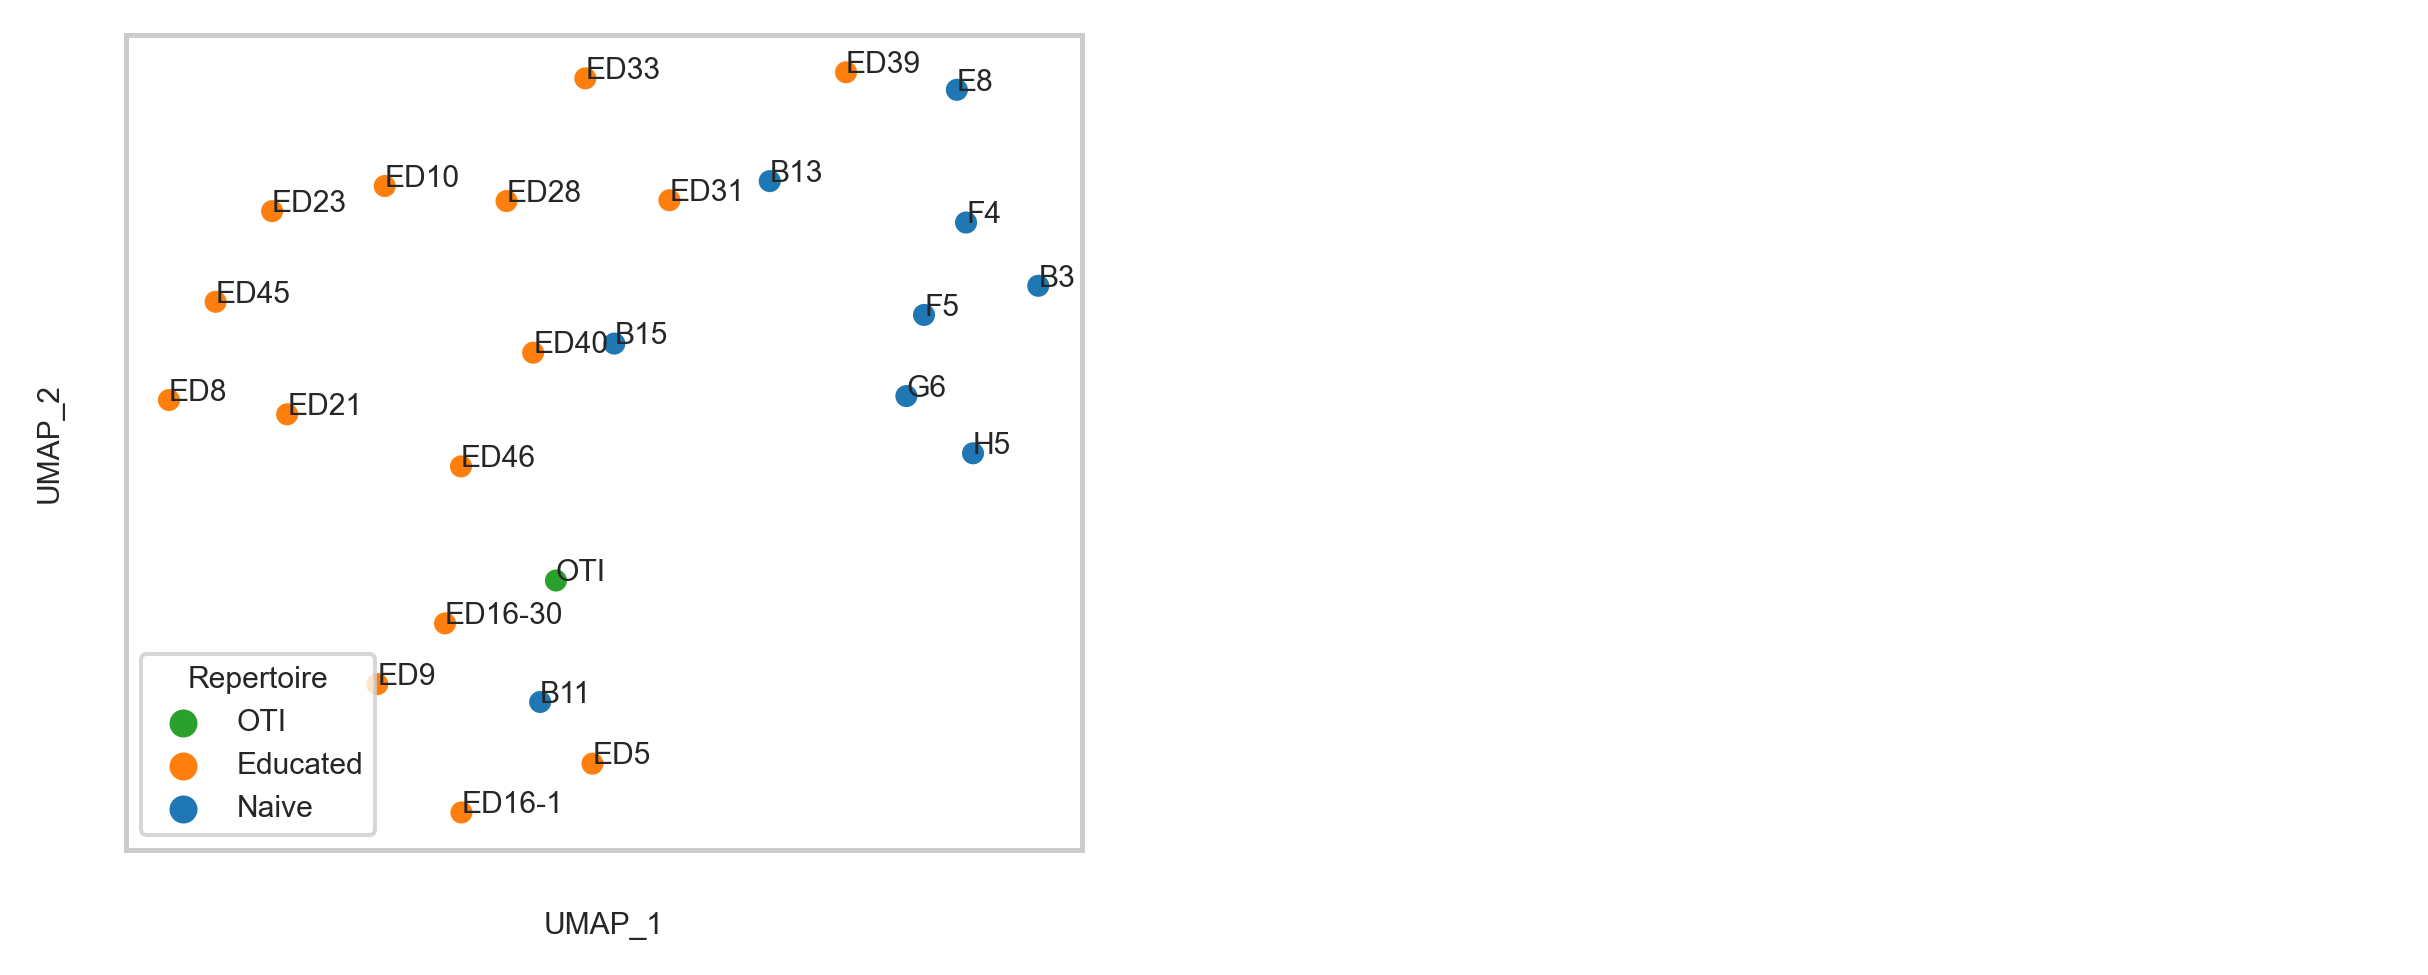

In [70]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.4), dpi=DPI)


gridspecs = {}
axes = {}

gridspecs['gs_12'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[1.5, 2],
)

axes['a'] = fig.add_subplot(gridspecs['gs_12'][0])
axes['b'] = fig.add_subplot(gridspecs['gs_12'][1])

sb.scatterplot(data=embedding, x='UMAP_1', y='UMAP_2', ax=axes['a'], hue='Repertoire', palette=palette_tcrs)
axes['a'].grid(False)
axes['a'].set_xticklabels([])
axes['a'].set_yticklabels([])

axes['b'].axis('off')

for index, row in embedding.iterrows():
    axes['a'].text(row['UMAP_1'], row['UMAP_2'], row['tcr'])
    
fig.tight_layout()
fig.savefig('figures/manuscript_supp_umap.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_umap.png', dpi=DPI, bbox_inches='tight')


## Positionwise Evaluation

In [71]:
def compute_class_score(g):
    return pd.Series({
        'Accuracy': (metrics.accuracy_score(g['is_activated'], g['pred_bin'])),
    })
pdf_classification['pred_bin'] = pdf_classification['pred'] > 0.5

In [72]:
mdf = pd.concat([
    pdf_classification.groupby(['tcr', 'mut_pos']) \
        .apply(compute_classification_metrics).reset_index(),
])
print(np.sum(mdf['AUC'].isna())/len(mdf))

0.395


In [73]:
acc = pdf_classification.groupby(['tcr', 'mut_pos']) \
        .apply(compute_class_score).reset_index()
#acc = acc.rename(columns={0: 'Accuracy'})
acc['Repertoire'] = acc['tcr'].apply(assign_repertoire)
acc['mut_pos'] = acc['mut_pos'] + 1
acc.groupby('Repertoire')['Accuracy'].mean()

Repertoire
Educated    0.706140
Naive       0.656433
OTI         0.868421
Name: Accuracy, dtype: float64

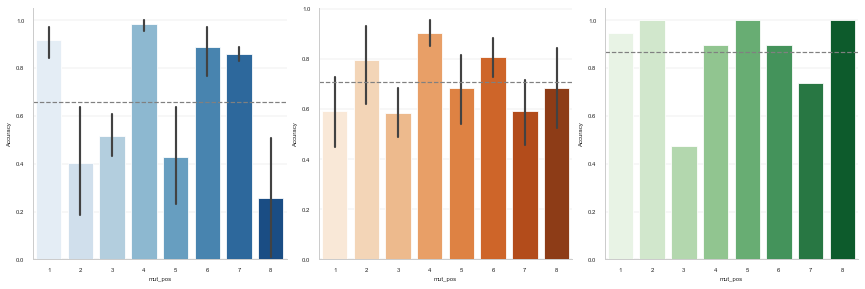

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
palette_cont = {
    'Educated': 'Oranges',
    'Naive': 'Blues',
    'OTI': 'Greens'
}
for i, rep in enumerate(acc['Repertoire'].unique()):
    tmp = acc[acc['Repertoire']==rep]
    sb.barplot(data=tmp, y='Accuracy', x='mut_pos', ax=axes[i], palette=palette_cont[rep])
    sb.despine(ax=axes[i])
    axes[i].axhline(tmp['Accuracy'].mean(), color='gray', linestyle='--')
plt.tight_layout()
plt.show()